In [1]:
# Install a pip package in the current Jupyter kernel
import sys
#!{sys.executable} -m pip install mne-connectivity

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import gc
from glob import glob
import numpy as np
import scipy as sp
import statistics, math
import random as rd
import pandas as pd
import dataframe_image as dfi
pd.options.display.float_format = '{:,.2f}'.format

from math import sqrt, ceil

from sklearn import metrics
from sklearn import decomposition, cluster
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from scipy.spatial.distance import correlation
from IPython.display import display

In [4]:
import mne
#import mne_connectivity

from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap, annotate_muscle_zscore, 
                               find_eog_events, find_ecg_events, ica_find_ecg_events, find_bad_channels_maxwell)
from mne.time_frequency import (tfr_morlet, tfr_multitaper, psd_multitaper, psd_welch, psd_array_multitaper, 
                                csd_array_fourier, csd_array_multitaper, csd_array_morlet)

from mne_connectivity import seed_target_indices, spectral_connectivity_epochs, spectral_connectivity_time

print(mne.__file__)
print(mne.__version__)

C:\Users\Lenovo\anaconda3\lib\site-packages\mne\__init__.py
0.23.4


In [5]:
import plotly.graph_objects as go
from gtda.time_series import SingleTakensEmbedding, TakensEmbedding, takens_embedding_optimal_parameters
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import BettiCurve, Scaler, Filtering, Amplitude, PersistenceEntropy, NumberOfPoints
from gtda.plotting import plot_point_cloud


In [6]:
# Configure the graphics engine

import matplotlib.pyplot as plt
plt.rc('figure', max_open_warning=200)
%matplotlib notebook
#%matplotlib inline
#%matplotlib qt

In [7]:
import seaborn as sns
# Apply the default theme
sns.set_theme()

In [8]:
# My modules
import my_varexplore as ve
import my_dimreduct as dr
import my_clustquality as cq
import my_stageprocess as spr

# Global variables

In [9]:
# Data destination paths

print(os.getcwd())
ft_root_path = os.getcwd()+'\\features\\m10\\'


C:\Users\Lenovo\PycharmProjects\Tibet


In [10]:
# Frequency bands

bands = [(0.9, 4, 'Delta (0.9-4 Hz)', 'D'), (4, 8, 'Theta (4-8 Hz)', 'T'), (8, 14, 'Alpha (8-14 Hz)', 'A'), 
         (14, 25, 'Beta (14-25 Hz)', 'B'), (25, 40, 'Gamma (25-40 Hz)', 'G')]

bands_test = [(0.9, 4, 'Delta (0.9-4 Hz)', 'D'), (4, 7, 'Theta (4-7 Hz)', 'T'), (7, 10, 'Alpha1 (7-10 Hz)','A1'), 
         (10, 13, 'Alpha2 (10-13 Hz)', 'A2'), (13, 20, 'Beta1 (13-20 Hz)', 'B1'), (20, 30, 'Beta2 (20-30 Hz)', 'B2'), 
         (30, 45, 'Gamma (30-45 Hz)', 'G')]

str_freq = [bands[i][3] for i in range(len(bands))]
#str_freq_rr = ['r'+_str for _str in str_freq]
str_freq_rr = str_freq
n_freq = len(str_freq_rr)


In [11]:
# Localization by scalp regions

regions = [(['Fp1','Fp2','Fpz'], 'Fp', 'Pre-frontal'), (['F7','F3','FT7','FC3'], 'LF', 'Left Frontal'), 
           (['Fz','FCz'], 'MF', 'Midline Frontal'), (['F4','F8','FC4','FT8'], 'RF', 'Right Frontal'),
           (['T3','TP7','T5'], 'LT', 'Left Temporal'), (['T4','TP8','T6'], 'RT', 'Right Temporal'), 
           (['C3','CP3'], 'LC', 'Left Central'), (['Cz','CPz'], 'MC', 'Midline Central'), (['C4','CP4'], 'RC', 'Right Central'),
           (['P3','P5'], 'LP', 'Left Parietal'), (['Pz'], 'MP', 'Midline Parietal'), (['P4','P6'], 'RP', 'Right Parietal'), 
           (['PO3','PO7','O1'], 'LO', 'Left Occipital'), (['POz','Oz'], 'MO', 'Midline Occipital'), 
           (['PO4','PO8','O2'], 'RO', 'Right Occipital')]
regions_plt = [(['Fp1','Fp2','Fpz'], 'Fp', 'Pre-frontal'), (['F7','F3','FT7','FC3'], 'LF', 'Left Frontal'), 
           (['Fz','FCz'], 'MF', 'Midline Frontal'), (['F4','F8','FC4','FT8'], 'RF', 'Right Frontal'),
           (['T3','TP7','T5'], 'LT', 'Left Temporal'), (['T4','TP8','T6'], 'RT', 'Right Temporal'), 
           (['C3','CP3','Cz','CPz','C4','CP4'], 'Cen', 'Central'), (['P3','P5','Pz','P4','P6'], 'Par', 'Parietal'), 
           (['PO3','PO7','O1','POz','Oz','PO4','PO8','O2'], 'Occ', 'Occipital')]

n_regions = len(regions)
n_regions_plt = len(regions_plt)



# Loading data

In [12]:
# Loading epochs

#epochs_filt_rr.save(os.path.join(ft_root_path, 'epochs_filt_rr-epo.fif'), overwrite=True)
epochs_filt_rr = mne.read_epochs(os.path.join(ft_root_path, 'epochs_filt_rr-epo.fif'))
print(epochs_filt_rr.get_data().shape)

sampling_rate = epochs_filt_rr.info['sfreq']
n_samples = epochs_filt_rr.__len__()
n_times = len(epochs_filt_rr.get_data()[0,0,:])

ch_names = epochs_filt_rr.ch_names
n_channels = len(ch_names)
print(ch_names)

Reading C:\Users\Lenovo\PycharmProjects\Tibet\features\m10\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
1046 matching events found
No baseline correction applied
0 projection items activated
(1046, 40, 501)
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'A1', 'T5', 'P3', 'Pz', 'P4', 'T6', 'A2', 'P5', 'PO3', 'POz', 'PO4', 'P6', 'PO7', 'O1', 'Oz', 'O2', 'PO8']


# Clusterization functions

In [16]:
# Функция для расчёта оценок качетва кластеризации
def cluster_metrics_noground(name, data, labels_pred):
    results = [name]
    df_data = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])

    # Define the metrics which require only data and predicted labels
    cluster_metrics = [
        metrics.silhouette_score,
        metrics.calinski_harabasz_score,
        metrics.davies_bouldin_score
    ]
    results += [m(data, labels_pred) for m in cluster_metrics]

    df_data.loc[0] = results
    
    return df_data

In [17]:
# Функция для расчёта оценок качества кластеризации
def cluster_metrics_ground(name, data, labels_pred, labels_true):
    results = [name]
    df_data = pd.DataFrame(columns=['Method', 'Homo', 'Compl', 'V-meas' 'ARI', 'AMI'])
    
    # Define the metrics which require data, true labels and predicted labels
    cluster_metrics_with_ground = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels_true, labels_pred) for m in cluster_metrics_with_ground] 
    
    df_data.loc[0] = results

    return df_data

In [18]:
def apply_cluster_method(data, cl_method, name, df_metrics, **kwargs):
    method = cl_method(**kwargs).fit(data)
    
    df = cluster_metrics_noground(name, data, method.labels_)
    df_metrics = df_metrics.drop(df_metrics[df_metrics['Method']==name].index, errors='ignore')
    df_metrics = pd.concat([df_metrics, df], ignore_index=True)
    
    return method, df_metrics

In [19]:
# Матрица связности для k соседних по времени эпох
#K_NEIGHBORS = 30

def knn_con_matr(X):
    n_samples = len(X)
    sm = sp.sparse.lil_matrix((n_samples, n_samples), dtype=np.int8)
    for i in range(n_samples):
        for j in range(n_samples):
            if abs(i-j)<=k_neighbours: sm[i,j]=1
    return sm.tocsr()


# TDA features

In [30]:
# Global variables

#tda_root_path = os.getcwd()+'\TDA_data\m10\\'  # R3
#excel_root_path = os.getcwd()+'\excel_data\m10\\'  # R3
tda_root_path = os.getcwd()+'\TDA_data\m10_40\R2\\'  # R2
excel_root_path = os.getcwd()+'\excel_data\m10_40\R2\\'  # R2
#print(tda_root_path)

#tda_bands = [(0.9, 4, 'D', 'Delta (0.9-4 Hz)', 15), (4, 8, 'T', 'Theta (4-8 Hz)', 12), (8, 14, 'A', 'Alpha (8-14 Hz)', 10), 
#             (14, 20, 'B1', 'Beta1 (14-20 Hz)', 8), (20, 25, 'B2', 'Beta2 (20-25 Hz)', 6), (25, 30, 'G1', 'Gamma1 (25-30 Hz)', 4), 
#             (30, 35, 'G2', 'Gamma2 (30-35 Hz)', 3), (35, 40, 'G3', 'Gamma3 (35-40 Hz)', 3)]

tda_bands = [(0.9, 4, 'D', 'Delta (0.9-4 Hz)', 15), (4, 8, 'T', 'Theta (4-8 Hz)', 12), (8, 14, 'A', 'Alpha (8-14 Hz)', 10), 
             (14, 25, 'B', 'Beta (14-25 Hz)', 7), (25, 40, 'G', 'Gamma (25-40 Hz)', 4)]

tda_metrics = [('landscape', 'land'), ('bottleneck','botl'), ('betti', 'bet')]#, ('wasserstein', 'wass')] 
#           ('silhouette', 'silh'), ('heat', 'heat'), ('persistence_image', 'img')]

#hom_dims = [1, 2] # Considered homology dimensions R3
hom_dims = [1] # Considered homology dimensions R2

#l_norms = [1, 2] # Norm orders for produsing features

persistence = VietorisRipsPersistence(
    homology_dimensions=hom_dims, 
    n_jobs=-1,
)

In [31]:
# Load persistent diagrams (re-referenced data)

# Full range
dir_name = 'pd_ft_rr_tda_loc'
target_dir = tda_root_path + dir_name

pd_ft_tda_loc_raw = []
print('Full range')
for i in range(n_regions):
    pd_ft_tda_loc_raw.append(np.load(os.path.join(target_dir, dir_name+'_'+str(i)+'.npy')))
    print(i, pd_ft_tda_loc_raw[i].shape)
    
# By spectrum
pd_ft_tda_loc_sp_raw = []
for _freq in range(len(tda_bands)):
    dir_name = 'pd_ft_rr_tda_loc_'+tda_bands[_freq][2]
    target_dir = tda_root_path + dir_name

    pd_ft_tda_loc_band = []
    print(tda_bands[_freq][3])
    for i in range(n_regions):
        pd_ft_tda_loc_band.append(np.load(os.path.join(target_dir, dir_name+'_'+str(i)+'.npy')))
        print(i, pd_ft_tda_loc_band[i].shape)
    pd_ft_tda_loc_sp_raw.append(pd_ft_tda_loc_band)

Full range
0 (1046, 74, 3)
1 (1046, 71, 3)
2 (1046, 74, 3)
3 (1046, 70, 3)
4 (1046, 71, 3)
5 (1046, 71, 3)
6 (1046, 72, 3)
7 (1046, 73, 3)
8 (1046, 70, 3)
9 (1046, 70, 3)
10 (1046, 71, 3)
11 (1046, 78, 3)
12 (1046, 71, 3)
13 (1046, 74, 3)
14 (1046, 71, 3)
Delta (0.9-4 Hz)
0 (1046, 76, 3)
1 (1046, 68, 3)
2 (1046, 81, 3)
3 (1046, 77, 3)
4 (1046, 73, 3)
5 (1046, 73, 3)
6 (1046, 69, 3)
7 (1046, 78, 3)
8 (1046, 81, 3)
9 (1046, 75, 3)
10 (1046, 73, 3)
11 (1046, 70, 3)
12 (1046, 73, 3)
13 (1046, 84, 3)
14 (1046, 66, 3)
Theta (4-8 Hz)
0 (1046, 112, 3)
1 (1046, 117, 3)
2 (1046, 108, 3)
3 (1046, 111, 3)
4 (1046, 106, 3)
5 (1046, 123, 3)
6 (1046, 109, 3)
7 (1046, 114, 3)
8 (1046, 104, 3)
9 (1046, 110, 3)
10 (1046, 126, 3)
11 (1046, 124, 3)
12 (1046, 118, 3)
13 (1046, 125, 3)
14 (1046, 122, 3)
Alpha (8-14 Hz)
0 (1046, 116, 3)
1 (1046, 115, 3)
2 (1046, 111, 3)
3 (1046, 110, 3)
4 (1046, 111, 3)
5 (1046, 107, 3)
6 (1046, 106, 3)
7 (1046, 108, 3)
8 (1046, 102, 3)
9 (1046, 104, 3)
10 (1046, 111, 3)
11 

In [32]:
# Fitering persistent diagrams

# Full range
pd_ft_tda_loc = []
print('Full range')
for _reg in range(n_regions):
    pd_ft_tda_loc.append(Filtering(epsilon=1e-07).fit_transform(pd_ft_tda_loc_raw[_reg]))
    print(pd_ft_tda_loc[_reg].shape)
    
# By spectrum
pd_ft_tda_loc_sp = []
for _freq in range(len(tda_bands)):
    pd_ft_tda_loc_band = []
    print(tda_bands[_freq][3])
    for _reg in range(n_regions):
        pd_ft_tda_loc_band.append(Filtering(epsilon=1e-07).fit_transform(pd_ft_tda_loc_sp_raw[_freq][_reg]))
        print(_reg, pd_ft_tda_loc_band[_reg].shape)
    pd_ft_tda_loc_sp.append(pd_ft_tda_loc_band)

Full range
(1046, 56, 3)
(1046, 57, 3)
(1046, 62, 3)
(1046, 50, 3)
(1046, 45, 3)
(1046, 54, 3)
(1046, 51, 3)
(1046, 58, 3)
(1046, 49, 3)
(1046, 51, 3)
(1046, 64, 3)
(1046, 60, 3)
(1046, 57, 3)
(1046, 60, 3)
(1046, 60, 3)
Delta (0.9-4 Hz)
0 (1046, 39, 3)
1 (1046, 11, 3)
2 (1046, 18, 3)
3 (1046, 9, 3)
4 (1046, 10, 3)
5 (1046, 9, 3)
6 (1046, 10, 3)
7 (1046, 10, 3)
8 (1046, 11, 3)
9 (1046, 10, 3)
10 (1046, 12, 3)
11 (1046, 11, 3)
12 (1046, 13, 3)
13 (1046, 26, 3)
14 (1046, 11, 3)
Theta (4-8 Hz)
0 (1046, 74, 3)
1 (1046, 64, 3)
2 (1046, 70, 3)
3 (1046, 66, 3)
4 (1046, 37, 3)
5 (1046, 67, 3)
6 (1046, 48, 3)
7 (1046, 69, 3)
8 (1046, 45, 3)
9 (1046, 64, 3)
10 (1046, 72, 3)
11 (1046, 77, 3)
12 (1046, 75, 3)
13 (1046, 68, 3)
14 (1046, 71, 3)
Alpha (8-14 Hz)
0 (1046, 78, 3)
1 (1046, 78, 3)
2 (1046, 86, 3)
3 (1046, 69, 3)
4 (1046, 52, 3)
5 (1046, 80, 3)
6 (1046, 68, 3)
7 (1046, 78, 3)
8 (1046, 56, 3)
9 (1046, 71, 3)
10 (1046, 83, 3)
11 (1046, 83, 3)
12 (1046, 85, 3)
13 (1046, 76, 3)
14 (1046, 81, 3

In [34]:
# Analyzing amplitudes (Averaged by region, full frequency range)

#pd_tda_features = pd_ft_tda_loc

df_ft_tda_loc = pd.DataFrame()
for _reg in range(n_regions):
    ft_num_dots = NumberOfPoints().fit_transform(pd_ft_tda_loc[_reg])
    ft_pers_entr = PersistenceEntropy(normalize=True, nan_fill_value=0).fit_transform(pd_ft_tda_loc[_reg])
    
    pd_ft = pd_ft_tda_loc[_reg]
    pd_ft_life = pd_ft[:,:,1] - pd_ft[:,:,0]
    pd_ft_life[pd_ft_life == 0] = np.nan # removing diagonal points
    pd_ft_bd2 = (pd_ft[:,:,0] + pd_ft[:,:,1]) / 2.0
    pd_ft_bd2[pd_ft_bd2 == 0] = np.nan # removing diagonal points
        
    life_max = np.nan_to_num(np.nanmax(pd_ft_life, axis=1))
    life_mean = np.nan_to_num(np.nanmean(pd_ft_life, axis=1))
    life_std = np.nan_to_num(np.nanstd(pd_ft_life, axis=1))
    #life_p25 = np.nan_to_num(np.nanpercentile(pd_ft_life, 25, axis=1))
    #life_med = np.nan_to_num(np.nanmedian(pd_ft_life, axis=1))
    life_p75 = np.nan_to_num(np.nanpercentile(pd_ft_life, 75, axis=1))
    life_kurt = np.nan_to_num(sp.stats.kurtosis(pd_ft_life, axis=1, nan_policy='omit'))
    life_skew = np.nan_to_num(sp.stats.skew(pd_ft_life, axis=1, nan_policy='omit'))
    life_sum = np.nan_to_num(np.nansum(pd_ft_life, axis=1))
    life_norm = np.linalg.norm(np.nan_to_num(pd_ft_life), ord=2, axis=1) # Identical with wasserstein distance

    bd2_max = np.nan_to_num(np.nanmax(pd_ft_bd2, axis=1))
    bd2_mean = np.nan_to_num(np.nanmean(pd_ft_bd2, axis=1))
    bd2_std = np.nan_to_num(np.nanstd(pd_ft_bd2, axis=1))
    #bd2_p25 = np.nan_to_num(np.nanpercentile(pd_ft_bd2, 25, axis=1))
    #bd2_med = np.nan_to_num(np.nanmedian(pd_ft_bd2, axis=1))
    bd2_p75 = np.nan_to_num(np.nanpercentile(pd_ft_bd2, 75, axis=1))
    bd2_kurt = np.nan_to_num(sp.stats.kurtosis(pd_ft_bd2, axis=1, nan_policy='omit'))
    bd2_skew = np.nan_to_num(sp.stats.skew(pd_ft_bd2, axis=1, nan_policy='omit'))
    bd2_sum = np.nan_to_num(np.nansum(pd_ft_bd2, axis=1))
    bd2_norm = np.linalg.norm(np.nan_to_num(pd_ft_bd2), ord=2, axis=1)
        
    df_ft_tda_loc['F_'+regions[_reg][1]+'_num_dots'] = ft_num_dots[:,0]
    df_ft_tda_loc['F_'+regions[_reg][1]+'_pers_entr'] = ft_pers_entr[:,0]
        
    df_ft_tda_loc['F_'+regions[_reg][1]+'_life_max'] = life_max
    df_ft_tda_loc['F_'+regions[_reg][1]+'_life_mean'] = life_mean
    df_ft_tda_loc['F_'+regions[_reg][1]+'_life_std'] = life_std
    #df_ft_tda_loc['F_'+regions[_reg][1]+'_life_p25'] = life_p25
    #df_ft_tda_loc['F_'+regions[_reg][1]+'_life_med'] = life_med
    df_ft_tda_loc['F_'+regions[_reg][1]+'_life_p75'] = life_p75
    df_ft_tda_loc['F_'+regions[_reg][1]+'_life_kurt'] = life_kurt
    df_ft_tda_loc['F_'+regions[_reg][1]+'_life_skew'] = life_skew
    df_ft_tda_loc['F_'+regions[_reg][1]+'_life_sum'] = life_sum
    df_ft_tda_loc['F_'+regions[_reg][1]+'_life_norm'] = life_norm

    df_ft_tda_loc['F_'+regions[_reg][1]+'_bd2_max'] = bd2_max
    df_ft_tda_loc['F_'+regions[_reg][1]+'_bd2_mean'] = bd2_mean
    df_ft_tda_loc['F_'+regions[_reg][1]+'_bd2_std'] = bd2_std
    #df_ft_tda_loc['F_'+regions[_reg][1]+'_bd2_p25'] = bd2_p25
    #df_ft_tda_loc['F_'+regions[_reg][1]+'_bd2_med'] = bd2_med
    df_ft_tda_loc['F_'+regions[_reg][1]+'_bd2_p75'] = bd2_p75
    df_ft_tda_loc['F_'+regions[_reg][1]+'_bd2_kurt'] = bd2_kurt
    df_ft_tda_loc['F_'+regions[_reg][1]+'_bd2_skew'] = bd2_skew
    df_ft_tda_loc['F_'+regions[_reg][1]+'_bd2_sum'] = bd2_sum
    df_ft_tda_loc['F_'+regions[_reg][1]+'_bd2_norm'] = bd2_norm
       
    for _ampl in range(len(tda_metrics)):
        ft_ampl = Amplitude(metric=tda_metrics[_ampl][0], n_jobs=-1).fit_transform(pd_ft_tda_loc[_reg])
        df_ft_tda_loc['F_'+regions[_reg][1]+'_'+tda_metrics[_ampl][1]] = ft_ampl[:,0]

# NaN values to zeros
df_ft_tda_loc = pd.DataFrame(np.nan_to_num(df_ft_tda_loc.to_numpy()), columns=df_ft_tda_loc.columns)

print(df_ft_tda_loc.to_numpy().shape) 

(1046, 315)


In [ ]:
# Check data in DataFrame

df_cols = [col for col in df_ft_tda_loc.columns if ('life' in col)]
s = df_ft_tda_loc[df_cols].describe().style.format('{:.2e}')
print(len(s.columns))
display(s)

df_cols = [col for col in df_ft_tda_loc.columns if ('bd2' in col)]
s = df_ft_tda_loc[df_cols].describe().style.format('{:.2e}')
print(len(s.columns))
display(s)

df_cols = [col for col in df_ft_tda_loc.columns if any(metr in col for (_, metr) in tda_metrics)]
s = df_ft_tda_loc[df_cols].describe().style.format('{:.2e}')
print(len(s.columns))
display(s)

df_cols = [col for col in df_ft_tda_loc.columns if any(s in col for s in ['num_dots', 'pers_entr'])]
s = df_ft_tda_loc[df_cols].describe().style.format('{:.2f}')
print(len(s.columns))
display(s)


In [238]:
# Log-scaling TDA features

log_suff = ['life_max', 'life_mean', 'life_std', 'life_p75', 'bd2_max', 'bd2_std', '_land', '_botl']
log_cols = [col for col in df_ft_tda_loc.columns if any(suf in col for suf in log_suff)]

df_ft_tda_loc_log = df_ft_tda_loc.copy()
df_ft_tda_loc_log[log_cols] = 10 * np.log10(df_ft_tda_loc[log_cols].copy())

# No need to log-scale some columns
#suffix = ['num_dots', 'pers_entr', 'life_kurt', 'life_skew', 'life_sum', 'life_norm', 'bd2_mean', 'bd2_p75', 
#          'bd2_kurt', 'bd2_skew', 'bd2_sum', 'bd2_norm', '_bet']

In [ ]:
# Analyzing amplitudes (Averaged by region, by spectrum)

df_ft_tda_loc_sp = []

for _freq in range(len(tda_bands)):
    df_ft_tda_loc_band = pd.DataFrame()
    for _reg in range(n_regions):
    
        ft_num_dots = NumberOfPoints().fit_transform(pd_ft_tda_loc_sp[_freq][_reg])
        ft_pers_entr = PersistenceEntropy(normalize=True, nan_fill_value=0).fit_transform(pd_ft_tda_loc_sp[_freq][_reg])
    
        pd_ft = pd_ft_tda_loc_sp[_freq][_reg]
        pd_ft_life = pd_ft[:,:,1] - pd_ft[:,:,0]
        pd_ft_life[pd_ft_life == 0] = np.nan # removing diagonal points
        pd_ft_bd2 = (pd_ft[:,:,0] + pd_ft[:,:,1]) / 2.0
        pd_ft_bd2[pd_ft_bd2 == 0] = np.nan # removing diagonal points
        
        life_max = np.nan_to_num(np.nanmax(pd_ft_life, axis=1))
        life_mean = np.nan_to_num(np.nanmean(pd_ft_life, axis=1))
        life_std = np.nan_to_num(np.nanstd(pd_ft_life, axis=1))
        #life_p25 = np.nan_to_num(np.nanpercentile(pd_ft_life, 25, axis=1))
        #life_med = np.nan_to_num(np.nanmedian(pd_ft_life, axis=1))
        life_p75 = np.nan_to_num(np.nanpercentile(pd_ft_life, 75, axis=1))
        life_kurt = np.nan_to_num(sp.stats.kurtosis(pd_ft_life, axis=1, nan_policy='omit'))
        life_skew = np.nan_to_num(sp.stats.skew(pd_ft_life, axis=1, nan_policy='omit'))
        life_sum = np.nan_to_num(np.nansum(pd_ft_life, axis=1))
        life_norm = np.linalg.norm(np.nan_to_num(pd_ft_life), ord=2, axis=1)
        
        bd2_max = np.nan_to_num(np.nanmax(pd_ft_bd2, axis=1))
        bd2_mean = np.nan_to_num(np.nanmean(pd_ft_bd2, axis=1))
        bd2_std = np.nan_to_num(np.nanstd(pd_ft_bd2, axis=1))
        #bd2_p25 = np.nan_to_num(np.nanpercentile(pd_ft_bd2, 25, axis=1))
        #bd2_med = np.nan_to_num(np.nanmedian(pd_ft_bd2, axis=1))
        bd2_p75 = np.nan_to_num(np.nanpercentile(pd_ft_bd2, 75, axis=1))
        bd2_kurt = np.nan_to_num(sp.stats.kurtosis(pd_ft_bd2, axis=1, nan_policy='omit'))
        bd2_skew = np.nan_to_num(sp.stats.skew(pd_ft_bd2, axis=1, nan_policy='omit'))
        bd2_sum = np.nan_to_num(np.nansum(pd_ft_bd2, axis=1))
        bd2_norm = np.linalg.norm(np.nan_to_num(pd_ft_bd2), ord=2, axis=1)

        df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_num_dots'] = ft_num_dots[:,0]
        df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_pers_entr'] = ft_pers_entr[:,0]
        
        df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_life_max'] = life_max
        df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_life_mean'] = life_mean
        df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_life_std'] = life_std
        #df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_life_p25'] = life_p25
        #df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_life_med'] = life_med
        df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_life_p75'] = life_p75
        #df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_life_kurt'] = life_kurt
        #df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_life_skew'] = life_skew
        df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_life_sum'] = life_sum
        df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_life_norm'] = life_norm

        df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_bd2_max'] = bd2_max
        df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_bd2_mean'] = bd2_mean
        df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_bd2_std'] = bd2_std
        #df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_bd2_p25'] = bd2_p25
        #df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_bd2_med'] = bd2_med
        df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_bd2_p75'] = bd2_p75
        #df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_bd2_kurt'] = bd2_kurt
        #df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_bd2_skew'] = bd2_skew
        df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_bd2_sum'] = bd2_sum
        df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_bd2_norm'] = bd2_norm
       
        for _ampl in range(len(tda_metrics)):
            ft_ampl = Amplitude(metric=tda_metrics[_ampl][0], n_jobs=-1).fit_transform(pd_ft_tda_loc_sp[_freq][_reg])
            df_ft_tda_loc_band[tda_bands[_freq][2]+'_'+regions[_reg][1]+'_'+tda_metrics[_ampl][1]] = ft_ampl[:,0]

    # Check NaN values
    nan_cols = df_ft_tda_loc_band.loc[:, df_ft_tda_loc_band.isnull().any()].columns
    print(nan_cols)
    display(df_ft_tda_loc_band[nan_cols][df_ft_tda_loc_band.isnull().T.any()])
    
    display(df_ft_tda_loc_band.describe())
    
    # NaN values to zeros
    df_ft_tda_loc_band = pd.DataFrame(np.nan_to_num(df_ft_tda_loc_band.to_numpy()), columns=df_ft_tda_loc_band.columns)
    
    df_ft_tda_loc_sp.append(df_ft_tda_loc_band)
    print(len(df_ft_tda_loc_band.columns))


In [81]:
# Scaling features

# Full range
ft_tda_loc_sc = StandardScaler().fit_transform(df_ft_tda_loc.to_numpy())
df_ft_tda_loc_sc = pd.DataFrame(ft_tda_loc_sc, columns=df_ft_tda_loc.columns)

# By spectrum
df_ft_tda_loc_sp_sc = []
for _freq in range(len(tda_bands)):
    ft_tda_loc_sc = StandardScaler().fit_transform(df_ft_tda_loc_sp[_freq].to_numpy())
    df_ft_tda_loc_sp_sc.append(pd.DataFrame(ft_tda_loc_sc, columns=df_ft_tda_loc_sp[_freq].columns))

In [ ]:
# Log-scaling TDA features

log_suff = ['life_max', 'life_mean', 'life_std', 'life_p75', 'bd2_max', 'bd2_std', '_land', '_botl']
df_ft_tda_loc_log_sp = df_ft_tda_loc_sp.copy()

for _fr in range(len(tda_bands)):
    log_cols = [col for col in df_ft_tda_loc_sp[_fr].columns if any(suf in col for suf in log_suff)]
    df_ft_tda_loc_log_sp[_fr][log_cols] = 10 * np.log10(df_ft_tda_loc_sp[_fr][log_cols].copy())

    #display(df_ft_tda_loc_sp[_fr][log_cols].describe())

In [ ]:
# Calculate IV for the features (Averaged by region, re-referenced)

st_bands, new_labels = spr.form_stage_bands(st_edges_median, n_samples)
n_stages = len(st_bands)

# Full range
IV_tda_list, WoE_tda_list = ve.IV_WoE_vars_clust(df_ft_tda_loc_sc, new_labels, n_bins=10)
print('Full range')
for i in range(n_stages):
    print('Cluster_' + str(i))
    df_IV_sorted = IV_tda_list[i].sort_values('IV', ascending = False)
    display(df_IV_sorted[df_IV_sorted['IV']>=0.5])
    
# By spectrum
IV_tda_list_sp = []
for _freq in range(len(tda_bands)):
    IV_list_band, WoE_list_band = ve.IV_WoE_vars_clust(df_ft_tda_loc_sp_sc[_freq], new_labels, n_bins=10)
    IV_tda_list_sp.append(IV_list_band)
    print(tda_bands[_freq][3])
    for i in range(n_stages):
        print('Cluster_' + str(i))
        df_IV_sorted = IV_tda_list_sp[_freq][i].sort_values('IV', ascending = False)
        display(df_IV_sorted[df_IV_sorted['IV']>=0.5])

In [33]:
# Export IV sheets to Excel

# Full range
dir_name = 'pd_ft_rr_tda_loc'
with pd.ExcelWriter(os.path.join(excel_root_path, dir_name+'_IV.xlsx')) as writer:
    for i in range(n_stages):
        df_IV_sorted = tda_IV_list[i].sort_values('IV', ascending = False)
        df_IV_sorted.to_excel(writer, sheet_name='Cluster_'+str(i))
        
# By spectrum
for _freq in range(len(tda_bands)):
    dir_name = 'pd_ft_rr_tda_loc_'+tda_bands[_freq][2]
    with pd.ExcelWriter(os.path.join(excel_root_path, dir_name+'_IV.xlsx')) as writer:
        for i in range(n_stages):
            df_IV_sorted = tda_IV_list_sp[_freq][i].sort_values('IV', ascending = False)
            df_IV_sorted.to_excel(writer, sheet_name='Cluster_'+str(i))

In [61]:
N_BEST_FEATURES = 10

df_ft_tda_loc_total = pd.concat([df_ft_tda_loc_sp_sc[i] for i in range(len(tda_bands))], axis=1)
df_ft_tda_loc_total = pd.concat([df_ft_tda_loc_total, df_ft_tda_loc_sc], axis=1)

df_features = df_ft_tda_loc_total
best_IV_list, best_WoE_list = ve.best_IV_WoE_vars_clust(df_features, new_labels, n_best_vars=N_BEST_FEATURES, 
                                                     corr_threshold=0.5, IV_threshold=0.4)


<IPython.core.display.Javascript object>


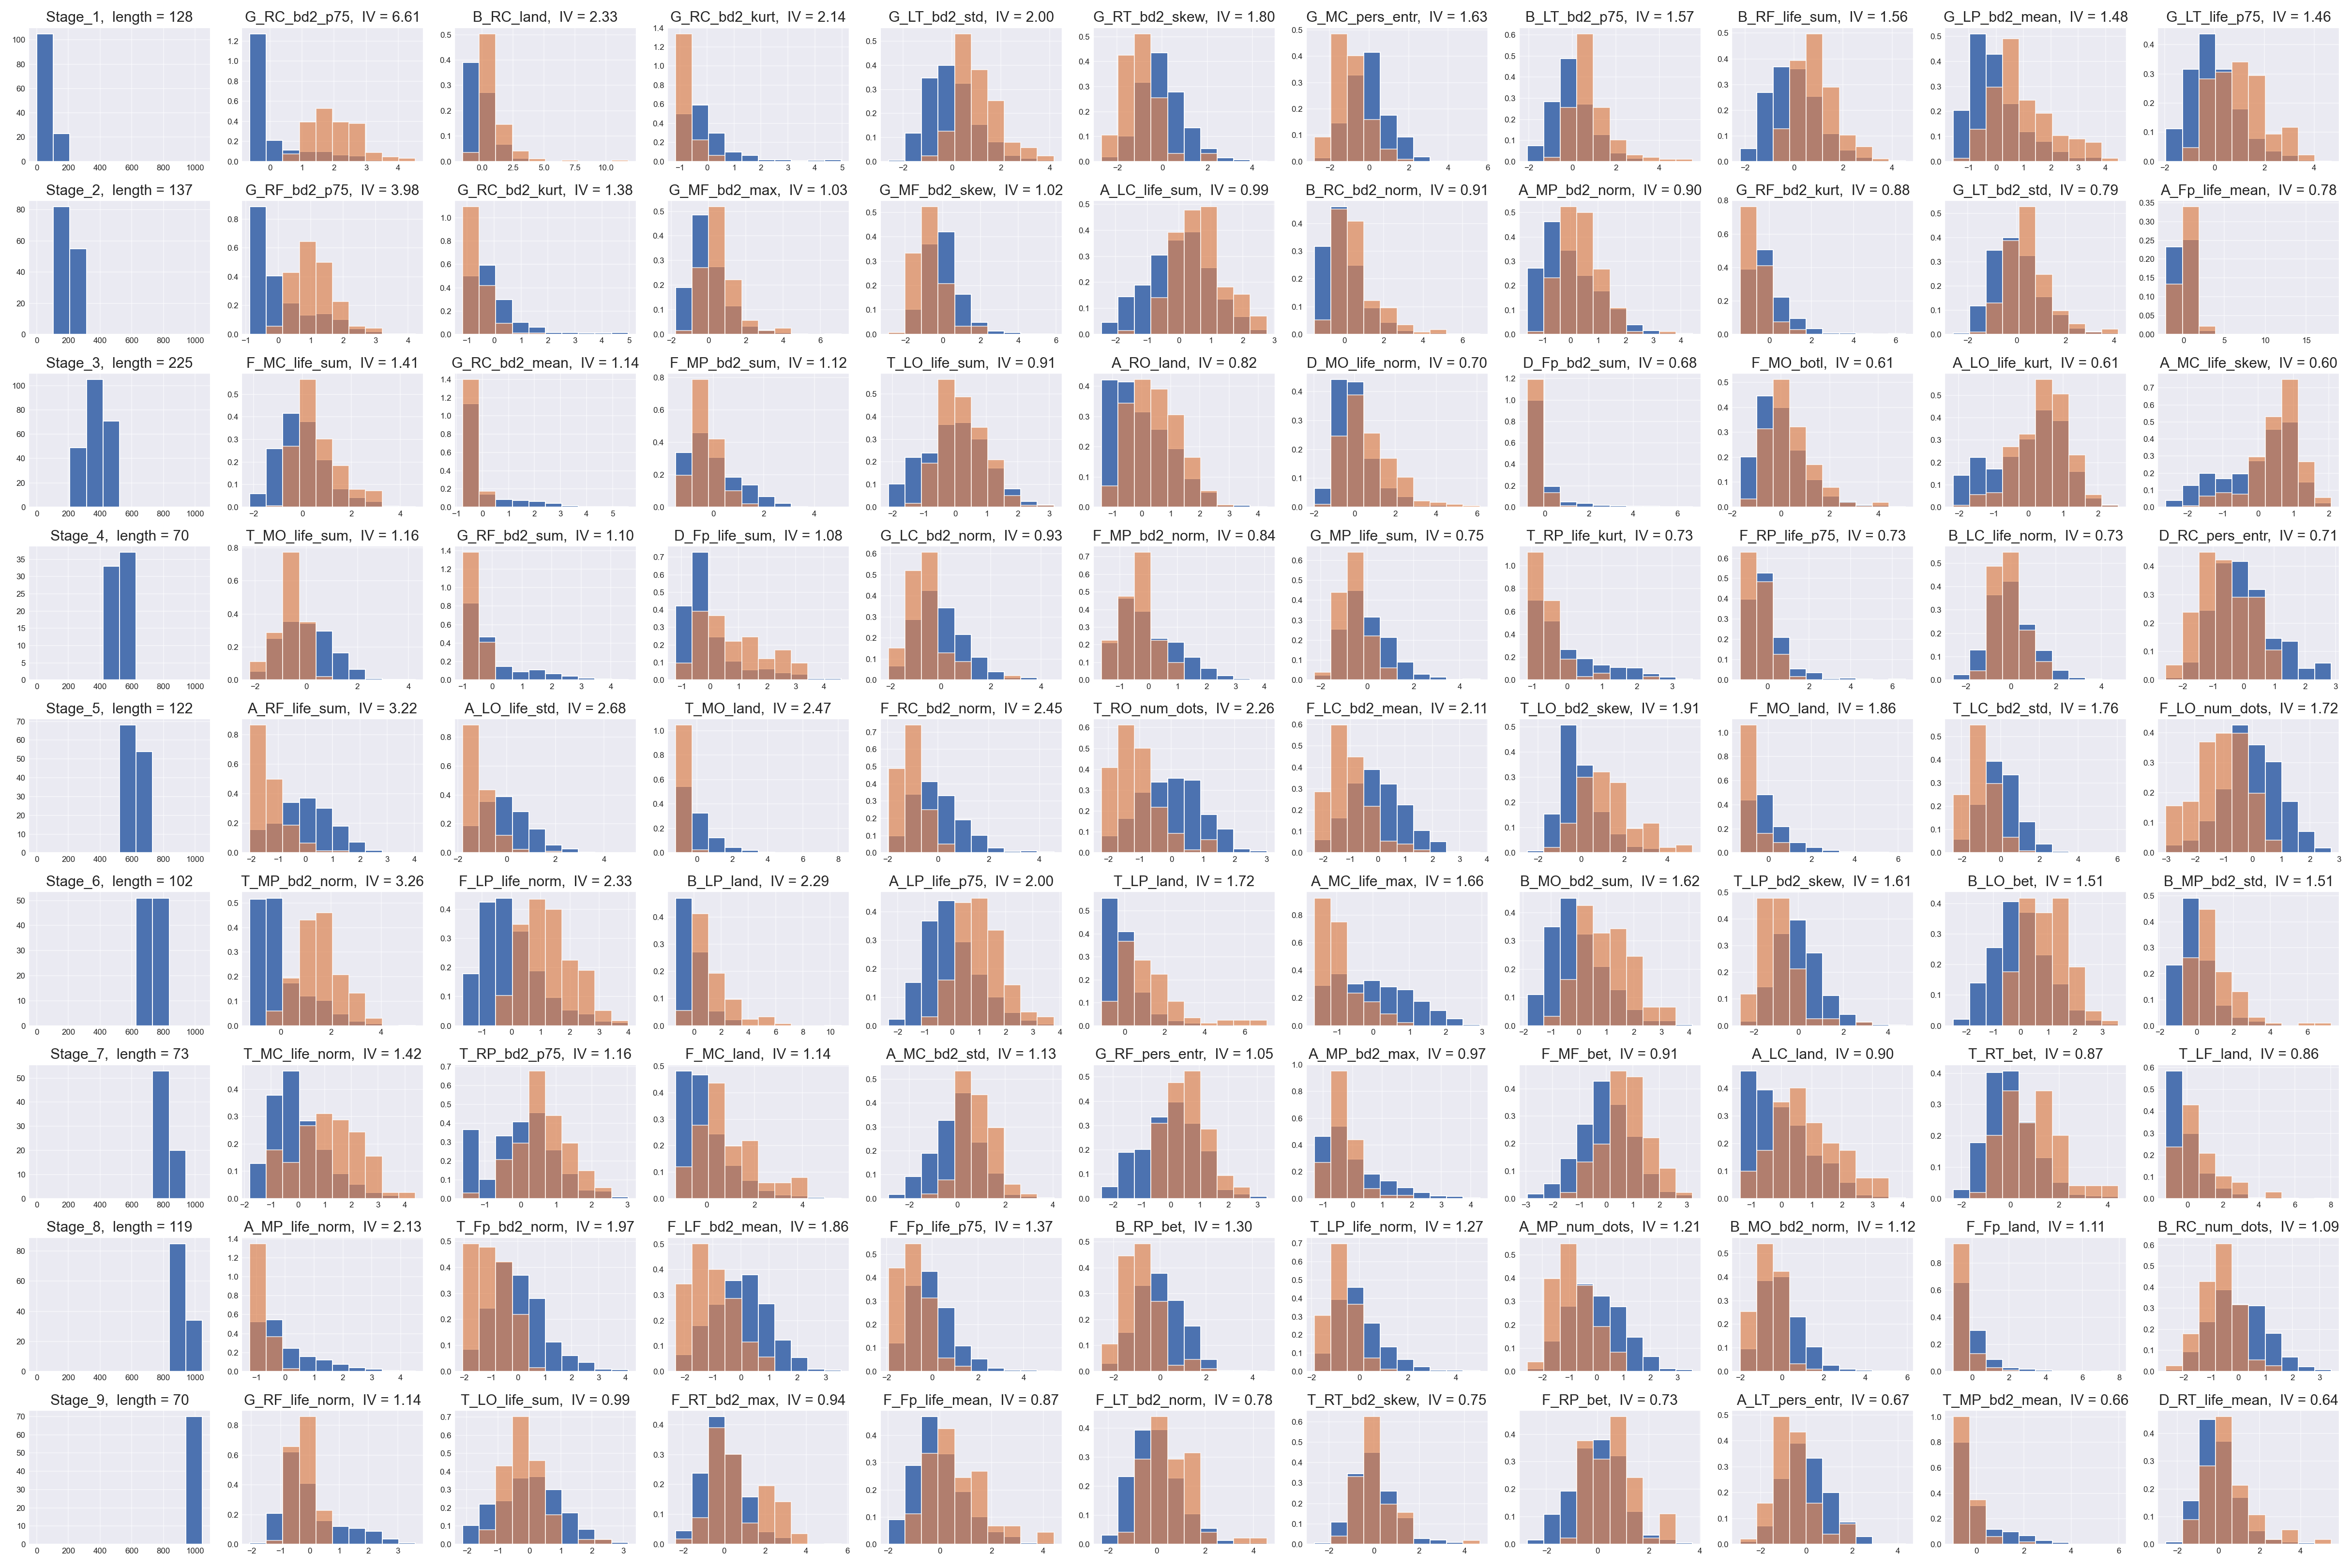

(<Figure size 3600x2400 with 99 Axes>,
 array([[<AxesSubplot:title={'center':'Stage_1,  length = 128'}>,
         <AxesSubplot:title={'center':'G_RC_bd2_p75,  IV = 6.61'}>,
         <AxesSubplot:title={'center':'B_RC_land,  IV = 2.33'}>,
         <AxesSubplot:title={'center':'G_RC_bd2_kurt,  IV = 2.14'}>,
         <AxesSubplot:title={'center':'G_LT_bd2_std,  IV = 2.00'}>,
         <AxesSubplot:title={'center':'G_RT_bd2_skew,  IV = 1.80'}>,
         <AxesSubplot:title={'center':'G_MC_pers_entr,  IV = 1.63'}>,
         <AxesSubplot:title={'center':'B_LT_bd2_p75,  IV = 1.57'}>,
         <AxesSubplot:title={'center':'B_RF_life_sum,  IV = 1.56'}>,
         <AxesSubplot:title={'center':'G_LP_bd2_mean,  IV = 1.48'}>,
         <AxesSubplot:title={'center':'G_LT_life_p75,  IV = 1.46'}>],
        [<AxesSubplot:title={'center':'Stage_2,  length = 137'}>,
         <AxesSubplot:title={'center':'G_RF_bd2_p75,  IV = 3.98'}>,
         <AxesSubplot:title={'center':'G_RC_bd2_kurt,  IV = 1.38'}>,
       

In [62]:
# R2 TDA features (averaged by region)

ve.plot_hist_best_vars(df_features, new_labels, best_IV_list)

# Predictive modelling

## Preprocessing data

In [56]:
gc.collect()

109

In [57]:
# IV threshold for features

st_bands, new_labels = spr.form_stage_bands(st_edges_median, n_samples)
n_stages = len(st_bands)

df_ft_sync_ind_orig = pd.concat([df_ft_coh_ind_loc_sc, df_ft_plv_ind_loc_sc], axis=1)
df_ft_psd_orig = pd.concat([df_ft_psd_loc_db_sc, df_ft_psd_ind_log_sc], axis=1)


IV_sync_ind_list, WoE_sync_ind_list = ve.IV_WoE_vars_clust(df_ft_sync_ind_orig, new_labels, n_bins=10)
IV_psd_list, WoE_psd_list = ve.IV_WoE_vars_clust(df_ft_psd_orig, new_labels, n_bins=10)
IV_sync_ind_best = []
IV_psd_best = []
for _st in range(n_stages):
    print('Stage_' + str(_st+1))
    # Synchrony Indices (Coherence & PLV)
    df_IV_sync_ind_sort = IV_sync_ind_list[_st].sort_values('IV', ascending = False)
    IV_sync_ind_best.append(df_IV_sync_ind_sort[df_IV_sync_ind_sort['IV']>=0.4])
    # PSD
    df_IV_psd_sort = IV_psd_list[_st].sort_values('IV', ascending = False)
    IV_psd_best.append(df_IV_psd_sort[df_IV_psd_sort['IV']>=0.4])
   
    print('Sync_Ind', len(df_IV_sync_ind_sort.index), len(IV_sync_ind_best[_st].index))
    print('PSD', len(df_IV_psd_sort.index), len(IV_psd_best[_st].index))


Stage_1
Sync_Ind 450 344
PSD 331 234
Stage_2
Sync_Ind 450 177
PSD 331 174
Stage_3
Sync_Ind 450 222
PSD 331 165
Stage_4
Sync_Ind 450 361
PSD 331 222
Stage_5
Sync_Ind 450 288
PSD 331 227
Stage_6
Sync_Ind 450 303
PSD 331 207
Stage_7
Sync_Ind 450 333
PSD 331 172
Stage_8
Sync_Ind 450 249
PSD 331 190
Stage_9
Sync_Ind 450 303
PSD 331 152


In [82]:
# IV threshold for TDA features

IV_threshold = 0.5

# Full range
IV_tda_list, WoE_tda_list = ve.IV_WoE_vars_clust(df_ft_tda_loc_sc, new_labels, n_bins=10)

IV_tda_best_full = []
for _st in range(n_stages):
    print('Stage_' + str(_st+1))
    df_IV_tda_sort = IV_tda_list[_st].sort_values('IV', ascending = False)
    IV_tda_best_full.append(df_IV_tda_sort[df_IV_tda_sort['IV']>=IV_threshold])
    print(len(df_IV_tda_sort), len(IV_tda_best_full[_st]))

# By spectrum
IV_tda_list_sp = []
for _freq in range(len(tda_bands)):
    IV_list_band, WoE_list_band = ve.IV_WoE_vars_clust(df_ft_tda_loc_sp_sc[_freq], new_labels, n_bins=10)
    IV_tda_list_sp.append(IV_list_band)

IV_tda_best_sp = []
for _fr in range(n_freq):
    IV_tda_best = []
    print(bands[_fr][2])
    for _st in range(n_stages):
        print('Stage_' + str(_st+1))
        df_IV_tda_sort = IV_tda_list_sp[_fr][_st].sort_values('IV', ascending = False)
        IV_tda_best.append(df_IV_tda_sort[df_IV_tda_sort['IV']>=IV_threshold])
        print(len(df_IV_tda_sort.index), len(IV_tda_best[_st].index))
    IV_tda_best_sp.append(IV_tda_best)

Stage_1
315 79
Stage_2
315 89
Stage_3
315 75
Stage_4
315 45
Stage_5
315 230
Stage_6
315 133
Stage_7
315 96
Stage_8
315 158
Stage_9
315 62
Delta (0.9-4 Hz)
Stage_1
255 42
Stage_2
255 0
Stage_3
255 15
Stage_4
255 31
Stage_5
255 17
Stage_6
255 19
Stage_7
255 11
Stage_8
255 17
Stage_9
255 3
Theta (4-8 Hz)
Stage_1
255 31
Stage_2
255 44
Stage_3
255 40
Stage_4
255 94
Stage_5
255 208
Stage_6
255 109
Stage_7
255 158
Stage_8
255 118
Stage_9
255 35
Alpha (8-14 Hz)
Stage_1
255 33
Stage_2
255 132
Stage_3
255 94
Stage_4
255 22
Stage_5
255 237
Stage_6
255 154
Stage_7
255 123
Stage_8
255 189
Stage_9
255 30
Beta (14-25 Hz)
Stage_1
255 97
Stage_2
255 31
Stage_3
255 1
Stage_4
255 17
Stage_5
255 220
Stage_6
255 174
Stage_7
255 4
Stage_8
255 194
Stage_9
255 0
Gamma (25-40 Hz)
Stage_1
255 180
Stage_2
255 100
Stage_3
255 34
Stage_4
255 123
Stage_5
255 121
Stage_6
255 57
Stage_7
255 50
Stage_8
255 83
Stage_9
255 40


In [ ]:
# Best IV TDA features (non-correlating)

N_BEST_FEATURES = 1000

df_ft_tda_orig = pd.concat([df_ft_rr_tda_loc_sp_sc[i] for i in range(len(tda_bands))], axis=1)
#df_ft_rr_tda_loc_total = pd.concat([df_ft_tda_orig, df_ft_rr_tda_loc_sc], axis=1)

df_features = df_ft_tda_orig
best_IV_list, best_WoE_list = ve.best_IV_WoE_vars_clust(df_features, new_labels, n_best_vars=N_BEST_FEATURES, 
                                                     corr_threshold=0.6, IV_threshold=0.5)
for _st in range(n_stages):
    print('Stage_' + str(_st+1))
    print(len(best_IV_list[_st].index))

In [27]:
# IV threshold for Coherence & PLV features

# Scaling features
ft_coh_loc_sc = StandardScaler().fit_transform(df_ft_coh_loc.to_numpy())
df_ft_coh_loc_sc = pd.DataFrame(ft_coh_loc_sc, columns=df_ft_coh_loc.columns)
ft_plv_loc_sc = StandardScaler().fit_transform(df_ft_plv_loc.to_numpy())
df_ft_plv_loc_sc = pd.DataFrame(ft_plv_loc_sc, columns=df_ft_plv_loc.columns)

df_ft_sync_orig = pd.concat([df_ft_coh_loc_sc, df_ft_plv_loc_sc], axis=1)

IV_sync_list, WoE_sync_list = ve.IV_WoE_vars_clust(df_ft_sync_orig, new_labels)
IV_sync_best = []
for _st in range(n_stages):
    print('Stage_' + str(_st+1))
    df_IV_sync_sort = IV_sync_list[_st].sort_values('IV', ascending = False)
    IV_sync_best.append(df_IV_sync_sort[df_IV_sync_sort['IV']>=0.5])
    print(len(df_IV_sync_sort.index), len(IV_sync_best[_st].index))

Stage_1
1050 804
Stage_2
1050 541
Stage_3
1050 580
Stage_4
1050 904
Stage_5
1050 783
Stage_6
1050 751
Stage_7
1050 891
Stage_8
1050 720
Stage_9
1050 826


In [59]:
# PCA decomposition (PSD features)

pca = decomposition.PCA(n_components=0.9)

# Binary classification
df_ft_psd_pca_bin = []
mult_cols = [] # multi-class columns

for _st in range(n_stages):
    print('Stage_' + str(_st+1))
    bin_cols = IV_psd_best[_st]['Variable'].to_numpy()
    mult_cols += list(bin_cols)
    print(len(bin_cols))

    ft_psd_pca = pca.fit_transform(df_ft_psd_orig[bin_cols])
    print(ft_psd_pca.shape)

    n_pca_comps = len(ft_psd_pca[0,:])
    pca_comp_names = ['PCA_'+str(i) for i in range(n_pca_comps)]
    df_ft_psd_pca_bin.append(pd.DataFrame(ft_psd_pca, columns=pca_comp_names))

# Multi-class classification
mult_cols = list(set(mult_cols))
print('Overall', len(mult_cols))
ft_psd_pca_mult = pca.fit_transform(df_ft_psd_orig[mult_cols])
print(ft_psd_pca_mult.shape)

n_pca_comps = len(ft_psd_pca_mult[0,:])
pca_comp_names = ['PCA_'+str(i) for i in range(n_pca_comps)]
df_ft_psd_pca_mult = pd.DataFrame(ft_psd_pca_mult, columns=pca_comp_names)


Stage_1
234
(1046, 20)
Stage_2
174
(1046, 17)
Stage_3
165
(1046, 12)
Stage_4
222
(1046, 21)
Stage_5
227
(1046, 21)
Stage_6
207
(1046, 19)
Stage_7
172
(1046, 15)
Stage_8
190
(1046, 19)
Stage_9
152
(1046, 15)
Overall 331
(1046, 24)


In [60]:
# PCA decomposition (Coherence & PLV Index features)

pca = decomposition.PCA(n_components=0.9)

# Binary classification
df_ft_sync_ind_pca_bin = []
mult_cols = [] # multi-class columns

for _st in range(n_stages):
    print('Stage_' + str(_st+1))
    bin_cols = IV_sync_ind_best[_st]['Variable'].to_numpy()
    mult_cols += list(bin_cols)
    print(len(bin_cols))

    ft_sync_ind_pca = pca.fit_transform(df_ft_sync_ind_orig[bin_cols])
    print(ft_sync_ind_pca.shape)

    n_pca_comps = len(ft_sync_ind_pca[0,:])
    pca_comp_names = ['PCA_'+str(i) for i in range(n_pca_comps)]
    df_ft_sync_ind_pca_bin.append(pd.DataFrame(ft_sync_ind_pca, columns=pca_comp_names))

# Multi-class classification
mult_cols = list(set(mult_cols))
print('Overall', len(mult_cols))
ft_sync_ind_pca_mult = pca.fit_transform(df_ft_sync_ind_orig[mult_cols])
print(ft_sync_ind_pca_mult.shape)

n_pca_comps = len(ft_sync_ind_pca_mult[0,:])
pca_comp_names = ['PCA_'+str(i) for i in range(n_pca_comps)]
df_ft_sync_ind_pca_mult = pd.DataFrame(ft_sync_ind_pca_mult, columns=pca_comp_names)


Stage_1
344
(1046, 55)
Stage_2
177
(1046, 38)
Stage_3
222
(1046, 41)
Stage_4
361
(1046, 51)
Stage_5
288
(1046, 41)
Stage_6
303
(1046, 45)
Stage_7
333
(1046, 43)
Stage_8
249
(1046, 40)
Stage_9
303
(1046, 47)
Overall 445
(1046, 60)


In [83]:
# PCA decomposition (TDA features)

pca = decomposition.PCA(n_components=0.9)

#drop_cols = [col for ]
df_ft_tda_orig = pd.concat([df_ft_tda_loc_sp_sc[_st] for _st in range(len(tda_bands))], axis=1)
#df_ft_tda_orig = pd.concat([df_ft_tda_orig, df_ft_tda_loc_sc], axis=1)

# Binary classification
df_ft_tda_pca_bin = []
mult_cols = [] # multi-class columns

for _st in range(n_stages):
    print('Stage_' + str(_st+1))
    #bin_cols = list(IV_tda_best_full[_st]['Variable'].to_numpy())
    bin_cols = []
    for _fr in range(n_freq):
        bin_cols += list(IV_tda_best_sp[_fr][_st]['Variable'].to_numpy())
    mult_cols += bin_cols
    print(len(bin_cols))

    ft_tda_pca = pca.fit_transform(df_ft_tda_orig[bin_cols])
    print(ft_tda_pca.shape)

    n_pca_comps = len(ft_tda_pca[0,:])
    pca_comp_names = ['PCA_'+str(i) for i in range(n_pca_comps)]
    df_ft_tda_pca_bin.append(pd.DataFrame(ft_tda_pca, columns=pca_comp_names))

# Multi-class classification
mult_cols = list(set(mult_cols))
print('Overall', len(mult_cols))
ft_tda_pca_mult = pca.fit_transform(df_ft_tda_orig[mult_cols])
print(ft_tda_pca_mult.shape)

n_pca_comps = len(ft_tda_pca_mult[0,:])
pca_comp_names = ['PCA_'+str(i) for i in range(n_pca_comps)]
df_ft_tda_pca_mult = pd.DataFrame(ft_tda_pca_mult, columns=pca_comp_names)


Stage_1
383
(1046, 56)
Stage_2
307
(1046, 36)
Stage_3
184
(1046, 20)
Stage_4
287
(1046, 45)
Stage_5
803
(1046, 94)
Stage_6
513
(1046, 63)
Stage_7
346
(1046, 41)
Stage_8
601
(1046, 73)
Stage_9
108
(1046, 18)
Overall 981
(1046, 121)


In [84]:
# PCA decomposition (PSD + TDA)

pca = decomposition.PCA(n_components=0.9)
df_ft_psd_tda_orig = pd.concat([df_ft_psd_orig, df_ft_tda_orig], axis=1)

# Binary classification
df_ft_psd_tda_pca_bin = []
mult_cols = [] # multi-class columns

for _st in range(n_stages):
    print('Stage_' + str(_st+1))
    bin_tda_cols = []
    #bin_tda_cols = list(IV_tda_best_full[_st]['Variable'].to_numpy())
    for _fr in range(n_freq):
        bin_tda_cols += list(IV_tda_best_sp[_fr][_st]['Variable'].to_numpy())
    
    bin_cols = list(IV_psd_best[_st]['Variable'].to_numpy()) + bin_tda_cols
    mult_cols += bin_cols
    print(len(bin_cols))

    ft_psd_tda_pca = pca.fit_transform(df_ft_psd_tda_orig[bin_cols])
    print(ft_psd_tda_pca.shape)

    n_pca_comps = len(ft_psd_tda_pca[0,:])
    pca_comp_names = ['PCA_'+str(i) for i in range(n_pca_comps)]
    df_ft_psd_tda_pca_bin.append(pd.DataFrame(ft_psd_tda_pca, columns=pca_comp_names))

# Multi-class classification
mult_cols = list(set(mult_cols))
print('Overall', len(mult_cols))
ft_psd_tda_pca_mult = pca.fit_transform(df_ft_psd_tda_orig[mult_cols])
print(ft_psd_tda_pca_mult.shape)

n_pca_comps = len(ft_psd_tda_pca_mult[0,:])
pca_comp_names = ['PCA_'+str(i) for i in range(n_pca_comps)]
df_ft_psd_tda_pca_mult = pd.DataFrame(ft_psd_tda_pca_mult, columns=pca_comp_names)


Stage_1
617
(1046, 65)
Stage_2
481
(1046, 45)
Stage_3
349
(1046, 27)
Stage_4
509
(1046, 56)
Stage_5
1030
(1046, 99)
Stage_6
720
(1046, 71)
Stage_7
518
(1046, 48)
Stage_8
791
(1046, 78)
Stage_9
260
(1046, 28)
Overall 1312
(1046, 124)


## Modelling

In [ ]:
# Random Forest tuning

rf = RandomForestClassifier()
rf_params = { "n_estimators": {50, 100, 200},
             "max_depth": {3, 5, 7, 'None'},
             "max_features": {2, 4, 6, 8, 'log2', 'sqrt'},
             "min_samples_split": {2, 4, 6}
            }



In [189]:
# Multiclass classification

X = df_ft_psd_pca_mult.to_numpy()
#X = df_ft_sync_ind_pca_mult.to_numpy()
#X = df_ft_tda_pca_mult.to_numpy()
#X = df_ft_psd_tda_pca_mult.to_numpy()
print(X.shape)
y = new_labels
#print(y.shape, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y)
    
clf_svc = svm.LinearSVC(C=1, multi_class='ovr').fit(X_train, y_train)
clf_lrCV = LogisticRegressionCV(Cs=10, cv=5, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
clf_rf = RandomForestClassifier().fit(X_train, y_train)
clf_xgb = XGBClassifier(max_depth=5, objective='multi:softmax', num_class=n_stages, n_estimators=100).fit(X_train, y_train)

y_pred_svc = clf_svc.predict(X_test)
y_pred_lrCV = clf_lrCV.predict(X_test)
y_pred_rf = clf_rf.predict(X_test)
y_pred_xgb = clf_xgb.predict(X_test)

acc = accuracy_score(y_test, y_pred_svc)
f1 = f1_score(y_test, y_pred_svc, average='macro')
print('Linear SVC: ', 'accuracy = ', acc, 'f1 = ', f1)
print(confusion_matrix(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))

acc = accuracy_score(y_test, y_pred_lrCV)
f1 = f1_score(y_test, y_pred_lrCV, average='macro')
print('LogRegrCV:', 'accuracy = ', acc, 'f1 = ', f1)
print(confusion_matrix(y_test, y_pred_lrCV))
print(classification_report(y_test, y_pred_lrCV))

acc = accuracy_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf, average='macro')
print('Random Forest:', 'accuracy = ', acc, 'f1 = ', f1)
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

acc = accuracy_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb, average='macro')
print('XGBoost:', 'accuracy = ', acc, 'f1 = ', f1)
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


(1046, 24)
[01:02:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Linear SVC:  accuracy =  0.7088305489260143 f1 =  0.6426686811091491
[[42  8  0  0  0  0  0  0  1]
 [ 3 52  0  0  0  0  0  0  0]
 [ 0  6 72  1  4  0  3  1  3]
 [ 0  0  3 14  3  2  2  3  1]
 [ 0  0  1  7 33  2  0  6  0]
 [ 0  0  0  1  0 40  0  0  0]
 [ 0  2  9  3  3  4  5  2  1]
 [ 0  1  7  0  3  1  3 30  3]
 [ 0  1  8  3  2  2  2  1  9]]
              precision    recall  f1-score   support

         0.0       0.93      0.82      0.87        51
         1.0       0.74      0.95      0.83        55
         2.0       0.72      0.80      0.76        90
         3.0       0.48      0.50      0.49        28
         4.0       0.69      0.67      0.68       

In [190]:
# Compute binary prediction scores (classes and probability) 

def predict_bin_compute(X_train, y_train, X_test, mdl_name):
    if mdl_name == 'Linear SVM':
        clf = svm.SVC(kernel='linear', C=1, probability=True).fit(X_train, y_train)

    if mdl_name == 'RBF SVM':
        clf = svm.SVC(kernel='rbf', C=1, probability=True).fit(X_train, y_train)

    if mdl_name == 'LogRegrCV':
        clf = LogisticRegressionCV(Cs=10, cv=5, solver='liblinear').fit(X_train, y_train)

    if mdl_name == 'RForest':
        clf = RandomForestClassifier(max_depth=6, n_estimators=1000).fit(X_train, y_train)
        
    if mdl_name == 'XGBoost':
        clf = XGBClassifier(eval_metric='logloss', max_depth=6, n_estimators=1000).fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,1]
    
    return y_pred, y_prob

In [191]:
# Binary classification

# Global variables
test_coef = 0.4 # Test sample percentage
mdl_names_bin = ['Linear SVM', 'RBF SVM', 'LogRegrCV']#, 'XGBoost']
datasets = ['PSD', 'TDA', 'Sync_Ind']#, 'PSD+TDA']
mdl_metrics_bin = ['Gini', 'Balanced Accuracy', 'F1 Score', 'Precision', 'Recall']
st_names = ['Stage_'+str(i+1) for i in range(n_stages)]

df_mdl_metrics = pd.DataFrame(index=pd.MultiIndex.from_product([st_names, mdl_names_bin], names=['Stage:', 'Model:']), 
                              columns=pd.MultiIndex.from_product([mdl_metrics_bin, datasets], names=['Metrics:', 'Datasets:']))
n_metrics = len(mdl_metrics_bin)
n_datasets = len(datasets)
n_models = len(mdl_names_bin)

# Predictions vector 
test_size = int(test_coef*n_samples)+1
y_test_st_ds = np.zeros((test_size, n_stages, n_datasets))
y_prob_st_ds_mdl = np.zeros((test_size, n_stages, n_datasets, n_models))

# Compute predictions
for _st in range(n_stages):
    metrics_ds_mdl = np.zeros((n_metrics, n_datasets, n_models))

    y = (new_labels==_st).astype(int) # binary target
    for _ds in range(n_datasets):
        if _ds == 0: # PSD
            X = df_ft_psd_pca_bin[_st].to_numpy()
        if _ds == 1: # TDA
            X = df_ft_tda_pca_bin[_st].to_numpy()
        if _ds == 2: # PSD+TDA
            X = df_ft_psd_tda_pca_bin[_st].to_numpy()
        if _ds == 3: # Sync_Ind
            X = df_ft_sync_ind_pca_bin[_st].to_numpy()
                
        # Splitting sample for current dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_coef, stratify=y)
        y_test_st_ds[:,_st,_ds] = y_test
        
        # Modelling
        for _mdl in range(n_models):
            # Make predictions
            y_pred, y_prob = predict_bin_compute(X_train, y_train, X_test, mdl_names_bin[_mdl])
            y_prob_st_ds_mdl[:,_st,_ds,_mdl] = y_prob
                        
            # Compute prediction metrics
            metrics_row = np.zeros(n_metrics)
            metrics_row[0] = 2*roc_auc_score(y_test, y_prob) - 1 # 'Gini'
            metrics_row[1] = balanced_accuracy_score(y_test, y_pred) # 'Balanced Accuracy'
            metrics_row[2] = f1_score(y_test, y_pred) # 'F1 Score'
            metrics_row[3] = precision_score(y_test, y_pred) # 'Precision'
            metrics_row[4] = recall_score(y_test, y_pred) # 'Recall'
            #print([round(x,2) for x in metrics_row])       
            
            metrics_ds_mdl[:,_ds,_mdl] = metrics_row
            
    # Create DataFrame with metrics
    for _mdl in range(n_models):
        new_row = {(mdl_metrics_bin[_metr], datasets[_ds]): metrics_ds_mdl[_metr,_ds,_mdl] 
                   for _metr in range(n_metrics) for _ds in range(n_datasets)}
        print([round(x,2) for x in new_row.values()])
        #print(new_row)
        df_mdl_metrics.loc[(st_names[_st], mdl_names_bin[_mdl]),:] = new_row
                

[0.99, 0.95, 0.98, 0.95, 0.85, 0.93, 0.9, 0.76, 0.85, 0.87, 0.8, 0.82, 0.92, 0.73, 0.88]
[0.99, 0.98, 0.99, 0.92, 0.95, 0.91, 0.88, 0.86, 0.88, 0.91, 0.8, 0.95, 0.84, 0.94, 0.82]
[0.99, 0.96, 0.99, 0.95, 0.91, 0.93, 0.9, 0.81, 0.88, 0.87, 0.78, 0.88, 0.92, 0.84, 0.88]
[0.85, 0.77, 0.83, 0.75, 0.67, 0.78, 0.61, 0.45, 0.63, 0.7, 0.54, 0.64, 0.55, 0.38, 0.62]
[0.96, 0.95, 0.96, 0.9, 0.78, 0.89, 0.81, 0.7, 0.82, 0.79, 0.86, 0.85, 0.84, 0.58, 0.8]
[0.87, 0.79, 0.87, 0.73, 0.68, 0.79, 0.57, 0.48, 0.61, 0.69, 0.66, 0.57, 0.49, 0.38, 0.65]
[0.79, 0.75, 0.81, 0.69, 0.75, 0.79, 0.55, 0.62, 0.69, 0.78, 0.67, 0.72, 0.42, 0.58, 0.66]
[0.89, 0.87, 0.91, 0.77, 0.78, 0.82, 0.68, 0.69, 0.73, 0.88, 0.83, 0.78, 0.56, 0.59, 0.69]
[0.8, 0.76, 0.82, 0.7, 0.73, 0.8, 0.55, 0.59, 0.69, 0.73, 0.63, 0.7, 0.44, 0.56, 0.68]
[0.88, 0.74, 0.7, 0.68, 0.7, 0.7, 0.5, 0.44, 0.46, 0.83, 0.46, 0.5, 0.36, 0.43, 0.43]
[0.93, 0.92, 0.86, 0.52, 0.53, 0.68, 0.07, 0.13, 0.51, 1.0, 0.67, 0.91, 0.04, 0.07, 0.36]
[0.88, 0.76, 0.8,

In [192]:
# Binary classification

# Global variables
test_coef = 0.4 # Test sample percentage
mdl_names_bin = ['Linear SVM', 'RBF SVM', 'LogRegrCV']#, 'XGBoost']
datasets = ['PSD', 'TDA', 'Sync_Ind']#, 'PSD+TDA']
mdl_metrics_bin = ['Gini', 'Balanced Accuracy', 'F1 Score', 'Precision', 'Recall']
st_names = ['Stage_'+str(i+1) for i in range(n_stages)]

df_mdl_metrics = pd.DataFrame(columns=pd.MultiIndex.from_product([st_names, mdl_names_bin], names=['Stage:', 'Model:']), 
                              index=pd.MultiIndex.from_product([mdl_metrics_bin, datasets], names=['Metric:', 'Dataset:']))
n_metrics = len(mdl_metrics_bin)
n_datasets = len(datasets)
n_models = len(mdl_names_bin)

# Predictions vector 
test_size = int(test_coef*n_samples)+1
y_test_st_ds = np.zeros((test_size, n_stages, n_datasets))
y_prob_st_ds_mdl = np.zeros((test_size, n_stages, n_datasets, n_models))

# Compute predictions
for _st in range(n_stages):
    metrics_ds_mdl = np.zeros((n_metrics, n_datasets, n_models))

    y = (new_labels==_st).astype(int) # binary target
    for _ds in range(n_datasets):
        if _ds == 0: # PSD
            X = df_ft_psd_pca_bin[_st].to_numpy()
        if _ds == 1: # TDA
            X = df_ft_tda_pca_bin[_st].to_numpy()
        if _ds == 2: # PSD+TDA
            X = df_ft_psd_tda_pca_bin[_st].to_numpy()
        if _ds == 3: # Sync_Ind
            X = df_ft_sync_ind_pca_bin[_st].to_numpy()
        #print(datasets[_ds], X.shape)
        
        # Splitting sample for current dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_coef, stratify=y)
        y_test_st_ds[:,_st,_ds] = y_test
                
        # Modelling
        for _mdl in range(n_models):
            # Make predictions
            y_pred, y_prob = predict_bin_compute(X_train, y_train, X_test, mdl_names_bin[_mdl])
            y_prob_st_ds_mdl[:,_st,_ds,_mdl] = y_prob
                        
            # Compute prediction metrics
            metrics_row = np.zeros(n_metrics)
            metrics_row[0] = 2*roc_auc_score(y_test, y_prob) - 1 # 'Gini'
            metrics_row[1] = balanced_accuracy_score(y_test, y_pred) # 'Balanced Accuracy'
            metrics_row[2] = f1_score(y_test, y_pred) # 'F1 Score'
            metrics_row[3] = precision_score(y_test, y_pred) # 'Precision'
            metrics_row[4] = recall_score(y_test, y_pred) # 'Recall'
            #print([round(x,2) for x in metrics_row])       
            
            metrics_ds_mdl[:,_ds,_mdl] = metrics_row
            #if (_ds==0):
                #print(st_names[_st], mdl_names_bin[_mdl])
                #print(confusion_matrix(y_test, y_pred))
            
    # Create DataFrame with metrics
    for _mdl in range(n_models):
        new_col = [metrics_ds_mdl[_metr,_ds,_mdl] for _metr in range(n_metrics) for _ds in range(n_datasets)]
        print([round(x,2) for x in new_col])
        df_mdl_metrics[(st_names[_st], mdl_names_bin[_mdl])] = new_col
                

[0.99, 0.98, 0.98, 0.95, 0.91, 0.96, 0.92, 0.86, 0.91, 0.94, 0.88, 0.89, 0.9, 0.84, 0.94]
[0.99, 0.99, 0.99, 0.95, 0.92, 0.95, 0.91, 0.89, 0.88, 0.92, 0.93, 0.84, 0.9, 0.84, 0.92]
[0.99, 0.98, 0.99, 0.95, 0.94, 0.96, 0.89, 0.9, 0.87, 0.85, 0.92, 0.81, 0.92, 0.88, 0.94]
[0.89, 0.79, 0.85, 0.84, 0.7, 0.75, 0.7, 0.52, 0.61, 0.68, 0.6, 0.68, 0.73, 0.45, 0.55]
[0.97, 0.94, 0.97, 0.91, 0.81, 0.88, 0.84, 0.71, 0.81, 0.85, 0.81, 0.84, 0.84, 0.64, 0.78]
[0.9, 0.83, 0.86, 0.83, 0.73, 0.76, 0.68, 0.57, 0.62, 0.66, 0.64, 0.73, 0.71, 0.51, 0.55]
[0.76, 0.74, 0.82, 0.7, 0.72, 0.79, 0.56, 0.59, 0.69, 0.69, 0.75, 0.77, 0.47, 0.49, 0.62]
[0.88, 0.84, 0.92, 0.74, 0.75, 0.81, 0.63, 0.64, 0.73, 0.78, 0.81, 0.85, 0.52, 0.53, 0.64]
[0.79, 0.74, 0.83, 0.71, 0.71, 0.79, 0.57, 0.56, 0.69, 0.68, 0.64, 0.74, 0.49, 0.5, 0.64]
[0.84, 0.76, 0.85, 0.71, 0.63, 0.73, 0.53, 0.37, 0.48, 0.71, 0.53, 0.47, 0.43, 0.29, 0.5]
[0.94, 0.93, 0.86, 0.57, 0.55, 0.66, 0.25, 0.19, 0.44, 1.0, 1.0, 0.69, 0.14, 0.11, 0.32]
[0.85, 0.81

In [172]:
display(df_mdl_metrics)

Metrics:           Gini               Balanced Accuracy                \
Datasets:           PSD  TDA Sync_Ind               PSD  TDA Sync_Ind   
Stage:  Model:                                                          
Stage_1 Linear SVM 0.99 0.92     0.98              0.94 0.86     0.93   
        RBF SVM    0.98 0.98     0.98              0.95 0.91     0.93   
        LogRegrCV  0.99 0.96     0.99              0.97 0.89     0.94   
Stage_2 Linear SVM 0.90 0.75     0.87              0.78 0.71     0.78   
        RBF SVM    0.94 0.92     0.95              0.93 0.81     0.87   
        LogRegrCV  0.91 0.79     0.88              0.80 0.70     0.77   
Stage_3 Linear SVM 0.79 0.73     0.83              0.73 0.70     0.79   
        RBF SVM    0.87 0.83     0.91              0.76 0.76     0.80   
        LogRegrCV  0.80 0.73     0.84              0.75 0.68     0.80   
Stage_4 Linear SVM 0.71 0.80     0.85              0.62 0.74     0.81   
        RBF SVM    0.84 0.87     0.96              0.53 0.61     0.77   
        LogRegrCV  0.72 0.80     0.91              0.61 0.63     0.79   
Stage_5 Linear SVM 0.91 0.79     0.88              0.78 0.76     0.87   
        RBF SVM    0.91 0.89     0.95              0.75 0.78     0.88   
        LogRegrCV  0.92 0.86     0.93              0.83 0.81     0.89   
Stage_6 Linear SVM 0.99 0.98     0.98              0.97 0.96     0.96   
        RBF SVM    1.00 0.98     0.98              0.95 0.96     0.99   
        LogRegrCV  1.00 0.98     0.98              0.96 0.94     0.96   
Stage_7 Linear SVM 0.61 0.75     0.80              0.50 0.61     0.69   
        RBF SVM    0.64 0.71     0.75              0.52 0.53     0.62   
        LogRegrCV  0.61 0.81     0.80              0.60 0.62     0.70   
Stage_8 Linear SVM 0.86 0.72     0.82              0.71 0.68     0.75   
        RBF SVM    0.88 0.86     0.90              0.66 0.67     0.71   
        LogRegrCV  0.85 0.78     0.88              0.70 0.70     0.79   
Stage_9 Linear SVM 0.62 0.76     0.74              0.50 0.55     0.58   
        RBF SVM    0.69 0.77     0.78              0.50 0.50     0.54   
        LogRegrCV  0.69 0.75     0.77              0.52 0.57     0.60   

Metrics:           F1 Score               Precision               Recall       \
Datasets:               PSD  TDA Sync_Ind       PSD  TDA Sync_Ind    PSD  TDA   
Stage:  Model:                                                                  
Stage_1 Linear SVM     0.88 0.74     0.87      0.87 0.72     0.87   0.90 0.76   
        RBF SVM        0.91 0.83     0.88      0.90 0.83     0.88   0.92 0.84   
        LogRegrCV      0.92 0.79     0.88      0.89 0.75     0.87   0.96 0.82   
Stage_2 Linear SVM     0.62 0.51     0.62      0.63 0.53     0.62   0.62 0.49   
        RBF SVM        0.79 0.68     0.77      0.70 0.71     0.75   0.91 0.65   
        LogRegrCV      0.64 0.49     0.62      0.63 0.52     0.65   0.65 0.45   
Stage_3 Linear SVM     0.60 0.55     0.70      0.71 0.68     0.76   0.52 0.47   
        RBF SVM        0.66 0.65     0.71      0.76 0.73     0.81   0.58 0.58   
        LogRegrCV      0.64 0.51     0.71      0.75 0.57     0.77   0.56 0.47   
Stage_4 Linear SVM     0.36 0.48     0.58      0.64 0.43     0.50   0.25 0.54   
        RBF SVM        0.13 0.34     0.67      0.67 0.86     0.88   0.07 0.21   
        LogRegrCV      0.32 0.37     0.64      0.44 0.53     0.68   0.25 0.29   
Stage_5 Linear SVM     0.70 0.56     0.70      0.90 0.54     0.63   0.57 0.59   
        RBF SVM        0.66 0.68     0.84      0.93 0.85     0.90   0.51 0.57   
        LogRegrCV      0.76 0.67     0.76      0.87 0.68     0.69   0.67 0.65   
Stage_6 Linear SVM     0.89 0.89     0.92      0.83 0.86     0.90   0.95 0.93   
        RBF SVM        0.92 0.95     0.99      0.95 0.97     1.00   0.90 0.93   
        LogRegrCV      0.90 0.87     0.93      0.88 0.84     0.93   0.93 0.90   
Stage_7 Linear SVM     0.00 0.30     0.44      0.00 0.39     0.48   0.00 0.24   
        RBF SVM        0.07

In [163]:
display(df_mdl_metrics)

Stage:                        Stage_1                      Stage_2          \
Model:                     Linear SVM RBF SVM LogRegrCV Linear SVM RBF SVM   
Metric:           Dataset:                                                   
Gini              PSD            0.99    0.99      0.98       0.88    0.91   
                  TDA            0.93    0.91      0.93       0.78    0.89   
                  Sync_Ind       0.89    0.88      0.87       0.62    0.77   
Balanced Accuracy PSD            0.90    0.95      0.85       0.62    0.71   
                  TDA            0.88    0.82      0.88       0.62    0.84   
                  Sync_Ind       0.95    0.97      0.97       0.76    0.96   
F1 Score          PSD            0.88    0.89      0.91       0.62    0.88   
                  TDA            0.77    0.79      0.81       0.36    0.80   
                  Sync_Ind       0.73    0.76      0.77       0.44    0.81   
Precision         PSD            0.80    0.82      0.86       0.31    0.78   
                  TDA            0.99    0.99      0.99       0.81    0.94   
                  Sync_Ind       0.93    0.99      0.97       0.72    0.86   
Recall            PSD            0.89    0.93      0.91       0.53    0.78   
                  TDA            0.92    0.86      0.86       0.57    0.82   
                  Sync_Ind       0.86    1.00      0.96       0.49    0.75   

Stage:                                  Stage_3                      Stage_4  \
Model:                     LogRegrCV Linear SVM RBF SVM LogRegrCV Linear SVM   
Metric:           Dataset:                                                     
Gini              PSD           0.89       0.75    0.86      0.78       0.84   
                  TDA           0.75       0.74    0.73      0.73       0.72   
                  Sync_Ind      0.58       0.61    0.61      0.59       0.55   
Balanced Accuracy PSD           0.60       0.68    0.74      0.69       0.68   
                  TDA           0.56       0.56    0.51      0.52       0.46   
                  Sync_Ind      0.78       0.77    0.87      0.77       0.79   
F1 Score          PSD           0.68       0.72    0.78      0.76       0.72   
                  TDA           0.44       0.58    0.71      0.63       0.54   
                  Sync_Ind      0.45       0.69    0.88      0.68       0.65   
Precision         PSD           0.44       0.50    0.59      0.59       0.46   
                  TDA           0.83       0.85    0.93      0.85       0.81   
                  Sync_Ind      0.73       0.76    0.85      0.78       0.78   
Recall            PSD           0.54       0.65    0.80      0.66       0.52   
                  TDA           0.57       0.73    0.88      0.67       0.45   
                  Sync_Ind      0.51       0.59    0.73      0.64       0.61   

Stage:                      ...   Stage_6    Stage_7                    \
Model:                      ... LogRegrCV Linear SVM RBF SVM LogRegrCV   
Metric:           Dataset:  ...                                          
Gini              PSD       ...      0.99       0.50    0.62      0.72   
                  TDA       ...      0.97       0.50    0.50      0.50   
                  Sync_Ind  ...      0.96       0.00    0.00      0.00   
Balanced Accuracy PSD       ...      0.97       0.00    0.00      0.00   
                  TDA       ...      0.95       0.00    0.00      0.00   
                  Sync_Ind  ...      0.98       0.72    0.63      0.72   
F1 Score          PSD       ...      0.96       0.66    0.57      0.63   
                  TDA       ...      0.90       0.40    0.24      0.39   
                  Sync_Ind  ...      0.88       0.48    0.80      0.67   
Precision         PSD       ...      0.93       0.34    0.14      0.28   
                  TDA       ...      0.99       0.81    0.86      0.84   
                  Sync_Ind  ...      0.97       0.71    0.50      0.73   
Recall            PSD       ...      0.94   

In [1]:
s = df_mdl_metrics.style.format('{:.2f}')
vert_border_dict = dict([((_col, mdl_names_bin[0]), [{"selector" :"td", "props": "border-left: 1px solid black"}, 
                                     {'selector': 'th', 'props': 'border-left: 1px solid black'}]) 
                    for _col in st_names])

hor_border_dict = dict([((_ind, datasets[-1]), [{"selector" :"td", "props": "border-bottom: 1px solid black"}, 
                                     {'selector': 'th', 'props': 'border-bottom: 1px solid black'}]) 
                    for _ind in mdl_metrics_bin])

s.set_table_styles([dict(selector="th", props=[('max-width', '80px')]), 
                    dict(selector="th.col_heading.level1", props=[("writing-mode", "vertical-rl"), 
                                                                  ('transform', 'rotateZ(180deg)'),])]
)

s.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: center;'},
    {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.2em;'},
    {'selector': 'td', 'props': 'text-align: center;'}], overwrite=False)

s.set_table_styles(hor_border_dict, overwrite=False, axis=1)
s.set_table_styles(vert_border_dict, overwrite=False, axis=0)
s.background_gradient(cmap='Greens')

display(s) 
dfi.export(s, 'Model metrics.png')                

NameError: name 'df_mdl_metrics' is not defined

PSD dataset


<IPython.core.display.Javascript object>


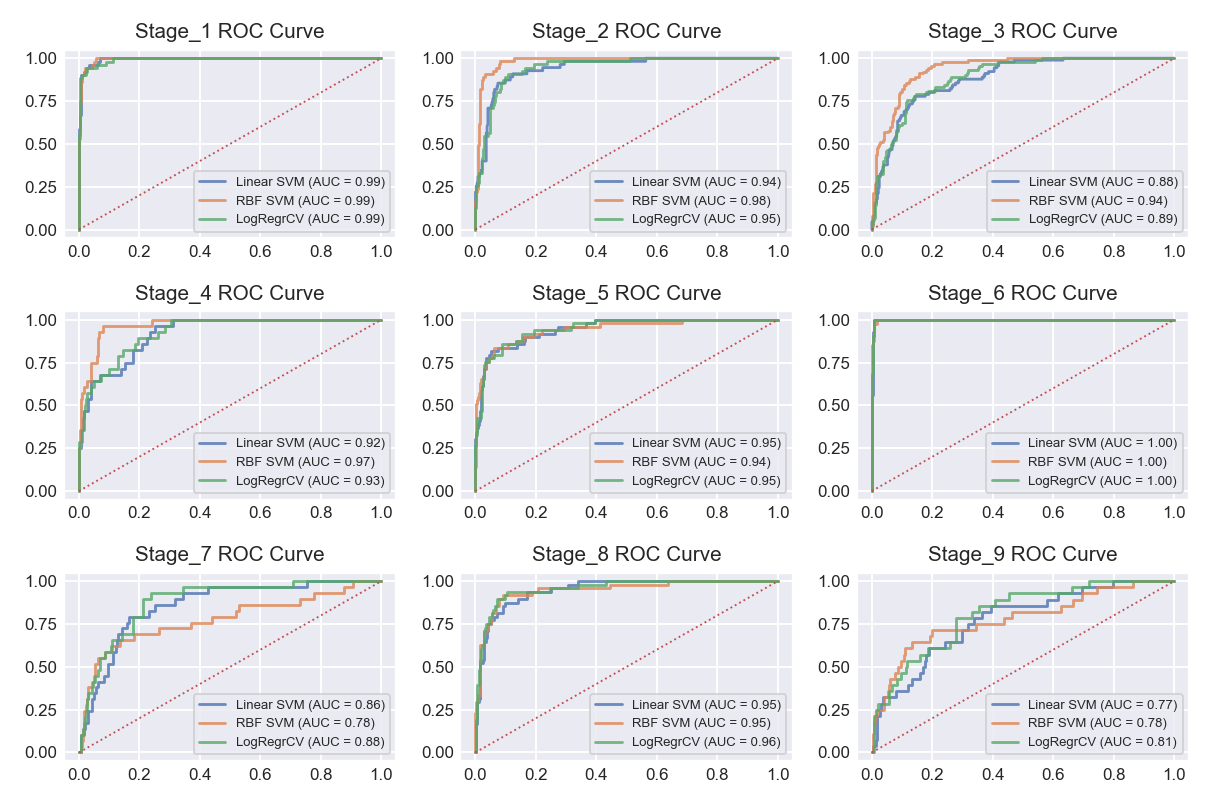

TDA dataset


<IPython.core.display.Javascript object>


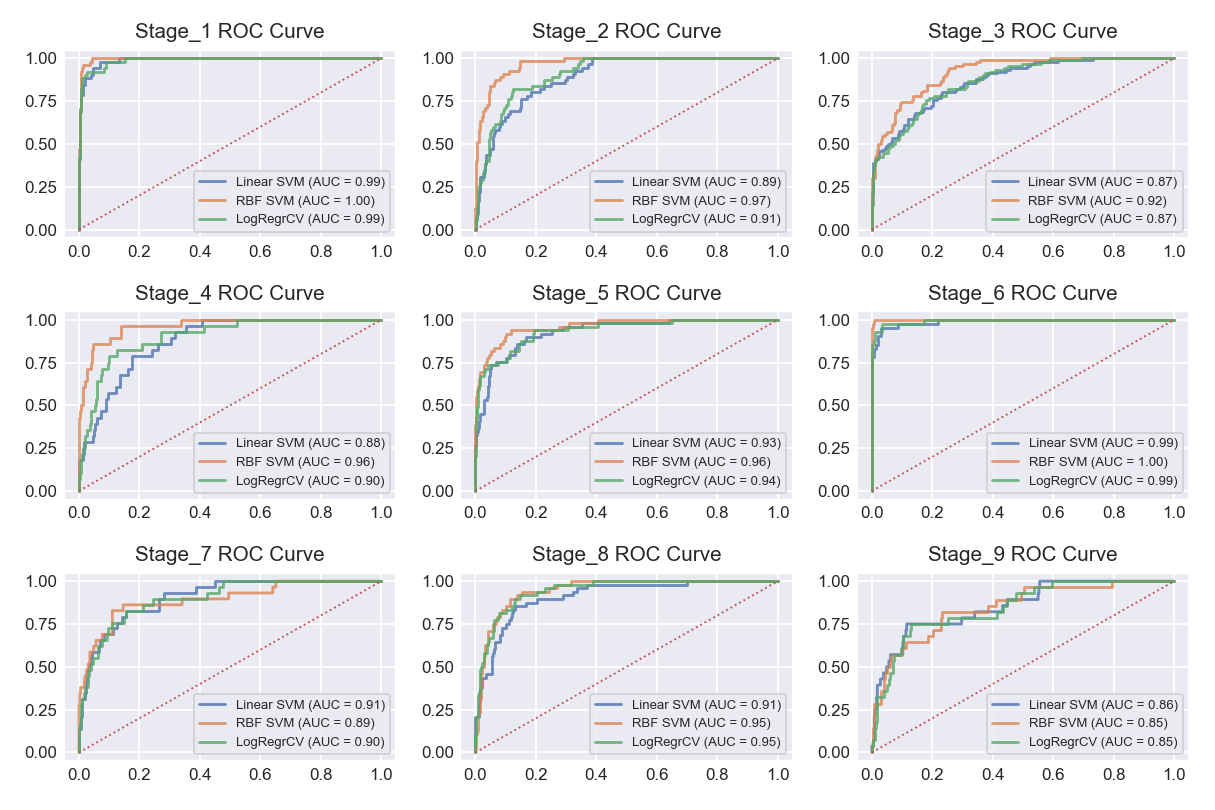

Sync_Ind dataset


<IPython.core.display.Javascript object>


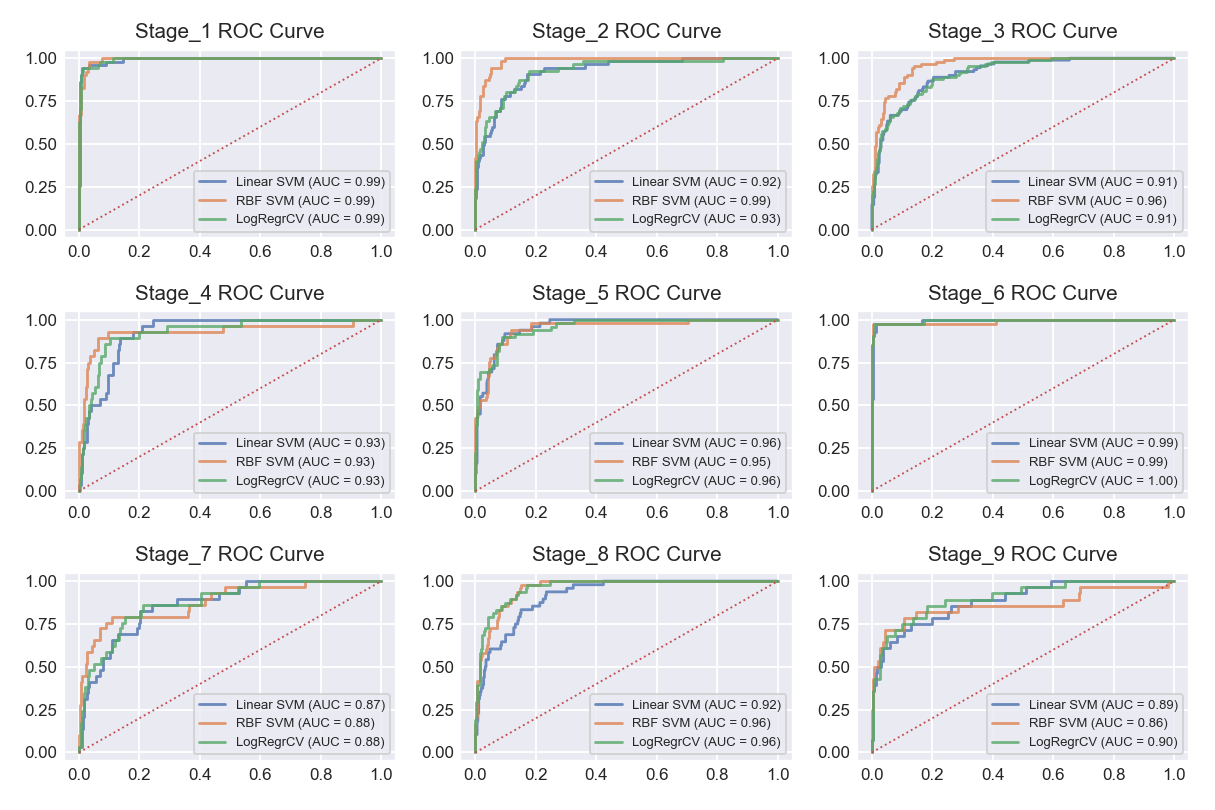

In [194]:
# Plotting ROC curves

n_cols = 3
n_rows = n_stages//3 + int(bool(n_stages%3))

for _ds in range(n_datasets):
    print(datasets[_ds] + ' dataset')
    
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 2*n_rows))
    plt.subplots_adjust(left=0.02)
    
    for _st in range(n_stages):
        for _mdl in range(n_models):
            RocCurveDisplay.from_predictions(y_test_st_ds[:,_st,_ds], y_prob_st_ds_mdl[:,_st,_ds,_mdl], 
                                             name=mdl_names_bin[_mdl], ax=axs[_st//n_cols, _st%n_cols], alpha=0.8)
                                                                                                          
        axs[_st//n_cols, _st%n_cols].plot([0, 1], [0, 1], linewidth=1, linestyle=":")
        axs[_st//n_cols, _st%n_cols].set_title('Stage_'+str(_st+1)+' ROC Curve', fontsize=11) 
        axs[_st//n_cols, _st%n_cols].tick_params(axis='both', labelsize=9, direction='in')#, grid_alpha=0.5)
        axs[_st//n_cols, _st%n_cols].set_xlabel(None)#"False Positive Rate", fontsize=9)
        axs[_st//n_cols, _st%n_cols].set_ylabel(None)#"True Positive Rate", fontsize=9)
        axs[_st//n_cols, _st%n_cols].legend(fontsize=7)#'x-small')
    
    plt.tight_layout()

    #handles, labels = axs[-1,-1].get_legend_handles_labels()
    #fig.suptitle('PSD in brain regions by spectrum')
    #fig.legend(handles, labels, loc='lower center', ncol=4)#, bbox_to_anchor=(0.5, -0.05))
    plt.savefig(datasets[_ds]+' ROC Curve plots.png')


Stage_1
(1046, 20)
Linear SVM F1 =  0.9
RBF SVM F1 =  0.93
LogRegrCV F1 =  0.92
Rndom Forest F1 =  0.76
XGBoost F1 =  0.87


<IPython.core.display.Javascript object>


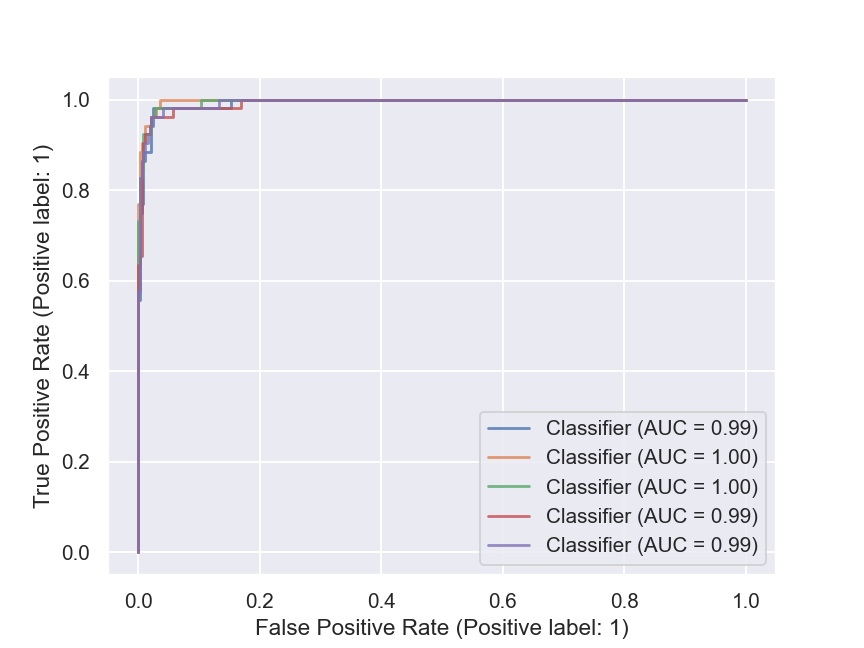

Stage_2
(1046, 17)
Linear SVM F1 =  0.7
RBF SVM F1 =  0.83
LogRegrCV F1 =  0.6
Rndom Forest F1 =  0.54
XGBoost F1 =  0.74


<IPython.core.display.Javascript object>


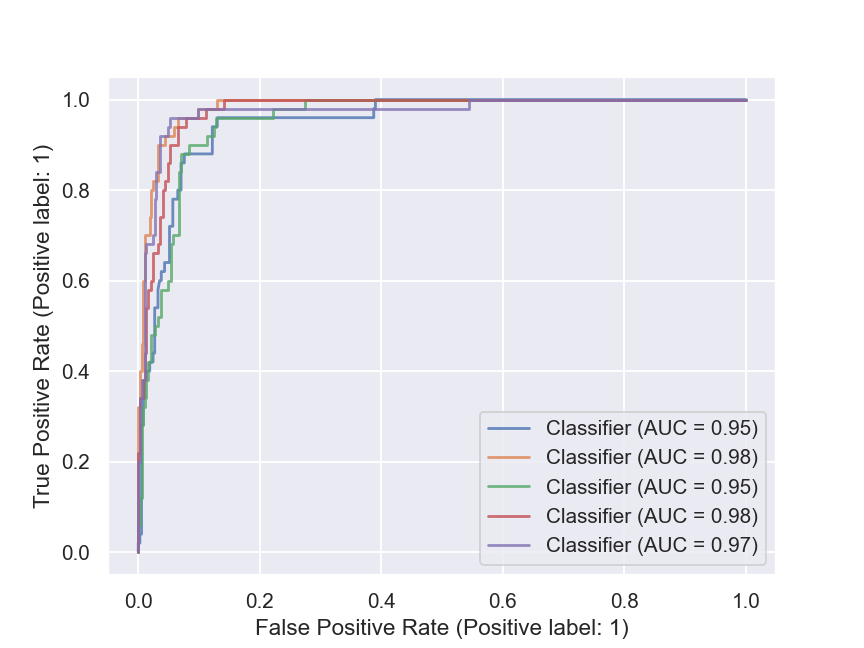

Stage_3
(1046, 12)
Linear SVM F1 =  0.57
RBF SVM F1 =  0.66
LogRegrCV F1 =  0.59
Rndom Forest F1 =  0.41
XGBoost F1 =  0.67


<IPython.core.display.Javascript object>


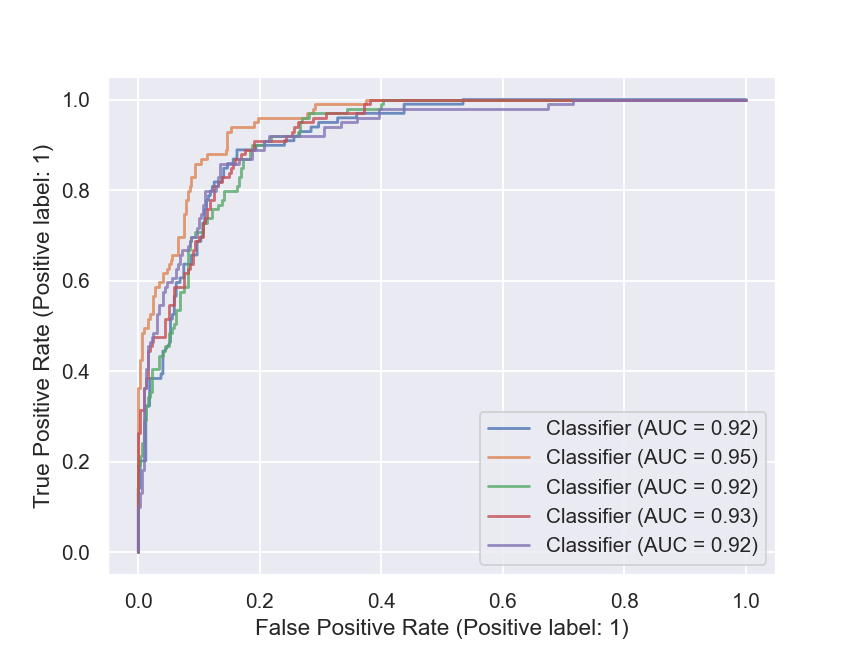

Stage_4
(1046, 21)
Linear SVM F1 =  0.49
RBF SVM F1 =  0.19
LogRegrCV F1 =  0.51
Rndom Forest F1 =  0.0
XGBoost F1 =  0.31


<IPython.core.display.Javascript object>


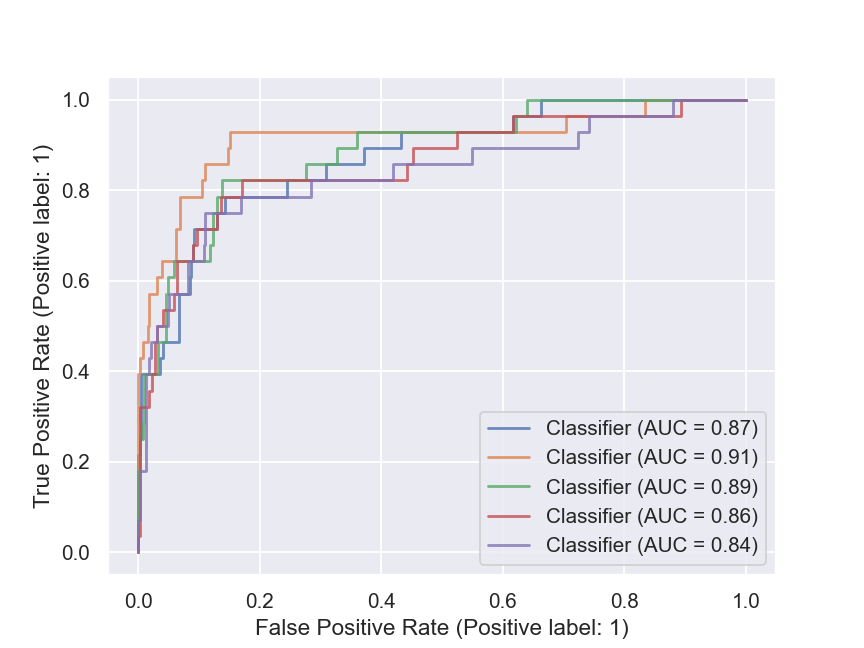

Stage_5
(1046, 21)
Linear SVM F1 =  0.78
RBF SVM F1 =  0.74
LogRegrCV F1 =  0.76
Rndom Forest F1 =  0.61
XGBoost F1 =  0.67


<IPython.core.display.Javascript object>


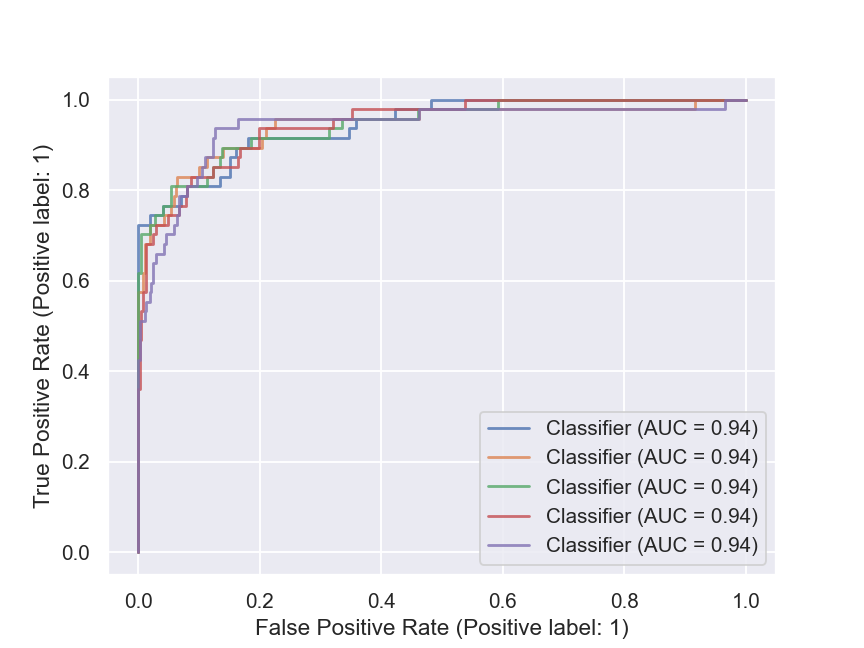

Stage_6
(1046, 19)
Linear SVM F1 =  0.89
RBF SVM F1 =  0.94
LogRegrCV F1 =  0.94
Rndom Forest F1 =  0.83
XGBoost F1 =  0.87


<IPython.core.display.Javascript object>


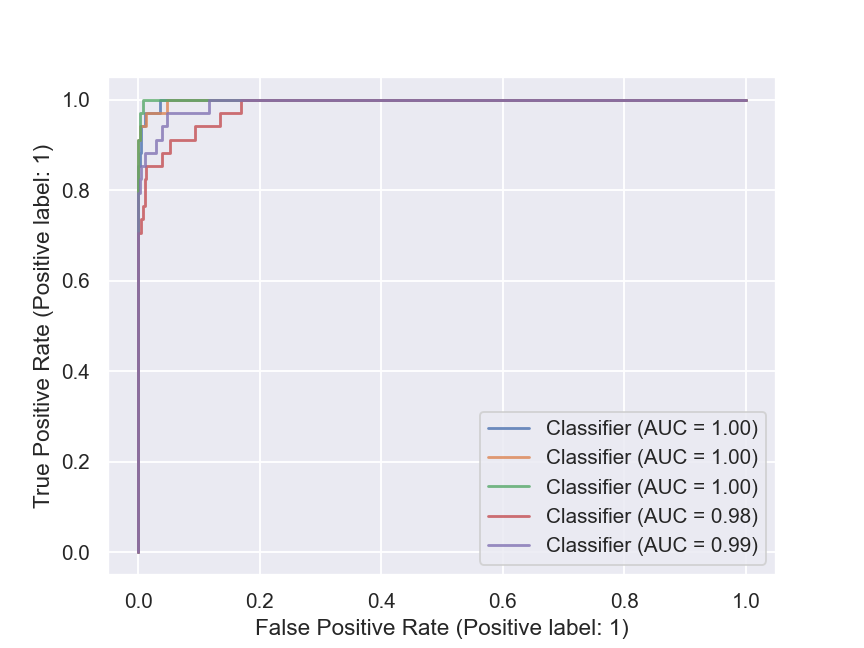

Stage_7
(1046, 15)
Linear SVM F1 =  0.0
RBF SVM F1 =  0.0
LogRegrCV F1 =  0.15
Rndom Forest F1 =  0.11
XGBoost F1 =  0.2


<IPython.core.display.Javascript object>


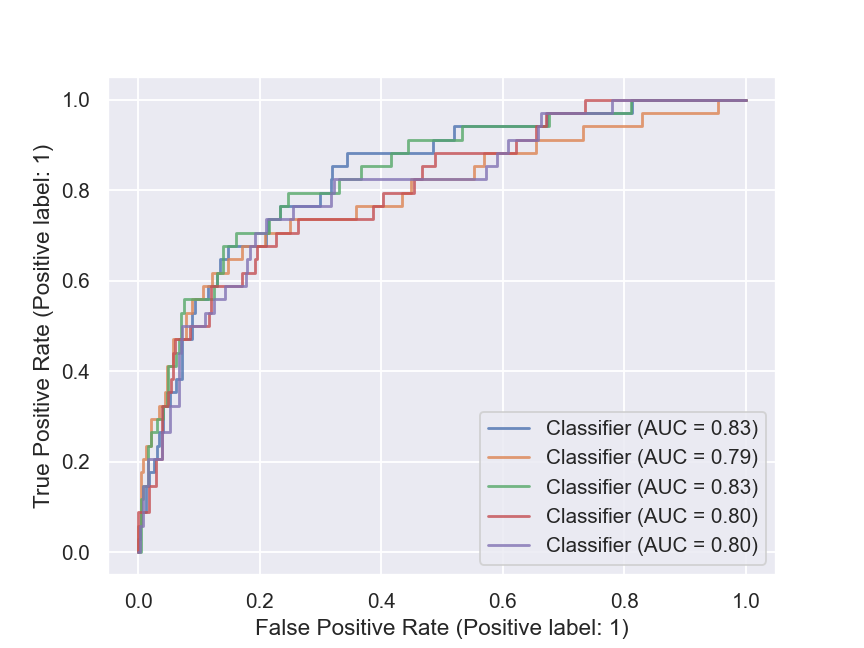

Stage_8
(1046, 19)
Linear SVM F1 =  0.62
RBF SVM F1 =  0.49
LogRegrCV F1 =  0.64
Rndom Forest F1 =  0.15
XGBoost F1 =  0.56


<IPython.core.display.Javascript object>


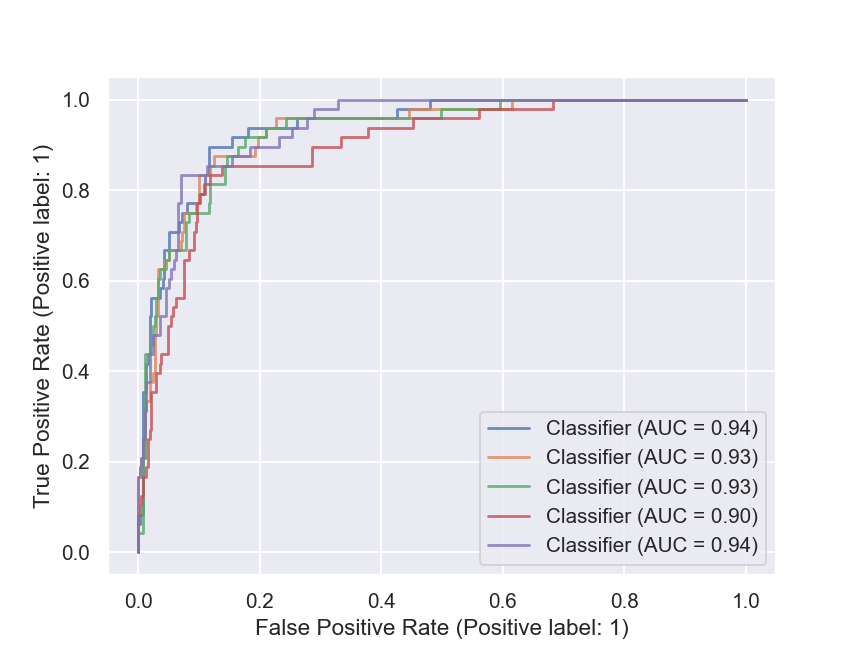

Stage_9
(1046, 15)
Linear SVM F1 =  0.0
RBF SVM F1 =  0.0
LogRegrCV F1 =  0.29
Rndom Forest F1 =  0.0
XGBoost F1 =  0.17


<IPython.core.display.Javascript object>


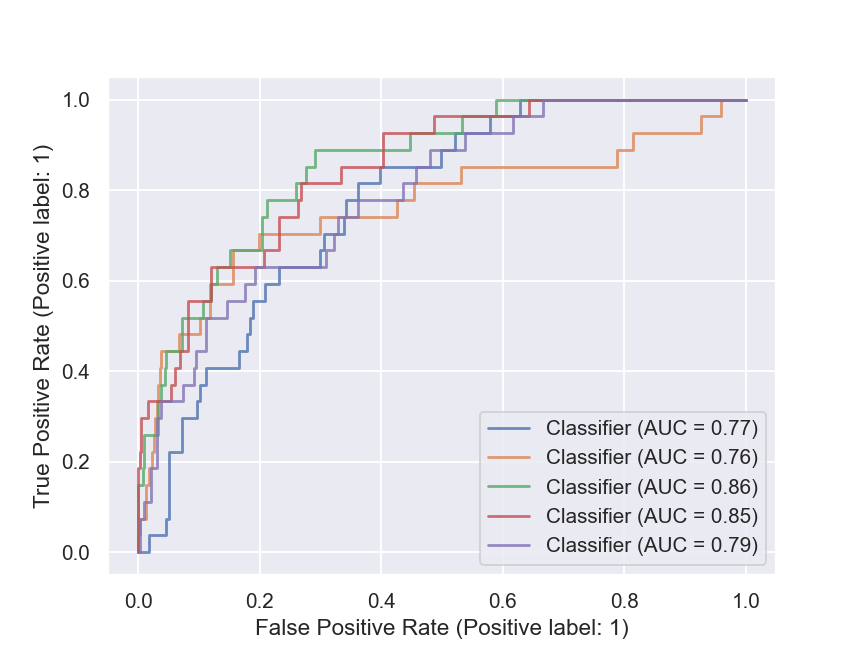

In [114]:
# Binary classification

for i in range(n_stages):
    print('Stage_' + str(i+1))
    X = df_ft_psd_pca_bin[i].to_numpy()
    print(X.shape)
    y = (new_labels==i).astype(int)
    #print(y.shape, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    
    clf_svc_lin = svm.SVC(kernel='linear', C=1, probability=True).fit(X_train, y_train)
    clf_svc_rbf = svm.SVC(kernel='rbf', C=1, probability=True).fit(X_train, y_train)
    #clf_lr = LogisticRegression(solver='liblinear', C=1).fit(X_train, y_train)
    clf_lrCV = LogisticRegressionCV(Cs=10, cv=5, solver='liblinear').fit(X_train, y_train)
    clf_rf = RandomForestClassifier(max_depth=6, n_estimators=1000).fit(X_train, y_train)
    clf_xgb = XGBClassifier(eval_metric='logloss', max_depth=6, n_estimators=1000).fit(X_train, y_train)

    y_pred_svc_lin = clf_svc_lin.predict(X_test)
    y_pred_svc_rbf = clf_svc_rbf.predict(X_test)
    #y_pred_lr = clf_lr.predict(X_test)
    y_pred_lrCV = clf_lrCV.predict(X_test)
    y_pred_rf = clf_rf.predict(X_test)
    y_pred_xgb = clf_xgb.predict(X_test)
    
    y_prob_svc_lin = clf_svc_lin.predict_proba(X_test)
    y_prob_svc_rbf = clf_svc_rbf.predict_proba(X_test)
    #y_prob_lr = clf_lr.predict_proba(X_test)
    y_prob_lrCV = clf_lrCV.predict_proba(X_test)
    y_prob_rf = clf_rf.predict_proba(X_test)
    y_prob_xgb = clf_xgb.predict_proba(X_test)

    
    print('Linear SVM', 'F1 = ', round(f1_score(y_test, y_pred_svc_lin), 2))
    print('RBF SVM', 'F1 = ', round(f1_score(y_test, y_pred_svc_rbf), 2))
    #print('LogRegr', 'F1 = ', round(f1_score(y_test, y_pred_lr), 2))
    print('LogRegrCV', 'F1 = ', round(f1_score(y_test, y_pred_lrCV), 2))
    print('Rndom Forest', 'F1 = ', round(f1_score(y_test, y_pred_rf), 2))
    print('XGBoost', 'F1 = ', round(f1_score(y_test, y_pred_xgb), 2))
    
    # Plotting ROC Curve
    ax = plt.figure().gca()
    
    svc_lin_disp = metrics.RocCurveDisplay.from_predictions(y_test, y_prob_svc_lin[:,1], ax=ax, alpha=0.8)
    svc_rbf_disp = metrics.RocCurveDisplay.from_predictions(y_test, y_prob_svc_rbf[:,1], ax=ax, alpha=0.8)
    #lr_disp = metrics.RocCurveDisplay.from_predictions(y_test, y_prob_lr[:,1], ax=ax, alpha=0.8)
    lrCV_disp = metrics.RocCurveDisplay.from_predictions(y_test, y_prob_lrCV[:,1], ax=ax, alpha=0.8)
    rf_disp = metrics.RocCurveDisplay.from_predictions(y_test, y_prob_rf[:,1], ax=ax, alpha=0.8)
    xgb_disp = metrics.RocCurveDisplay.from_predictions(y_test, y_prob_xgb[:,1], ax=ax, alpha=0.8)
    

# Topomap

In [32]:
print((new_labels==0).astype(int))

[1 1 1 ... 0 0 0]
